In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [45,30]
plt.rc('font', size = 20)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#download data from Yahoo Finance
name = 'AAPL'
ticker = yfinance.Ticker(name)
appl = ticker.history(interval ='1d', start = '2016-01-01', end = '2019-09-01')

In [3]:
rappl =(appl['Close'].diff())
rappl = rappl.replace(np.nan, 0)

In [4]:
appl['return'] = rappl

In [5]:
appl

,Open,High,Low,Close,Volume,Dividends,Stock Splits,return
Date,,,,,,,,
2016-01-04,23.620694,24.256043,23.480273,24.251438,270597600,0.0,0,0.000000
2016-01-05,24.343515,24.366535,23.574653,23.643711,223164000,0.0,0,-0.607727
2016-01-06,23.148780,23.565441,22.989944,23.181007,273829600,0.0,0,-0.462704
2016-01-07,22.716013,23.049801,22.198066,22.202669,324377600,0.0,0,-0.978338
2016-01-08,22.686083,22.814994,22.274027,22.320066,283192000,0.0,0,0.117397
...,...,...,...,...,...,...,...,...
2019-08-26,50.559933,50.886586,50.363450,50.714664,104174400,0.0,0,0.945580
2019-08-27,51.051135,51.220602,49.987671,50.142403,103493200,0.0,0,-0.572262
2019-08-28,50.127667,50.525543,49.936096,50.478878,63755200,0.0,0,0.336475


# Check for autocorrlation and stationarity in adj close

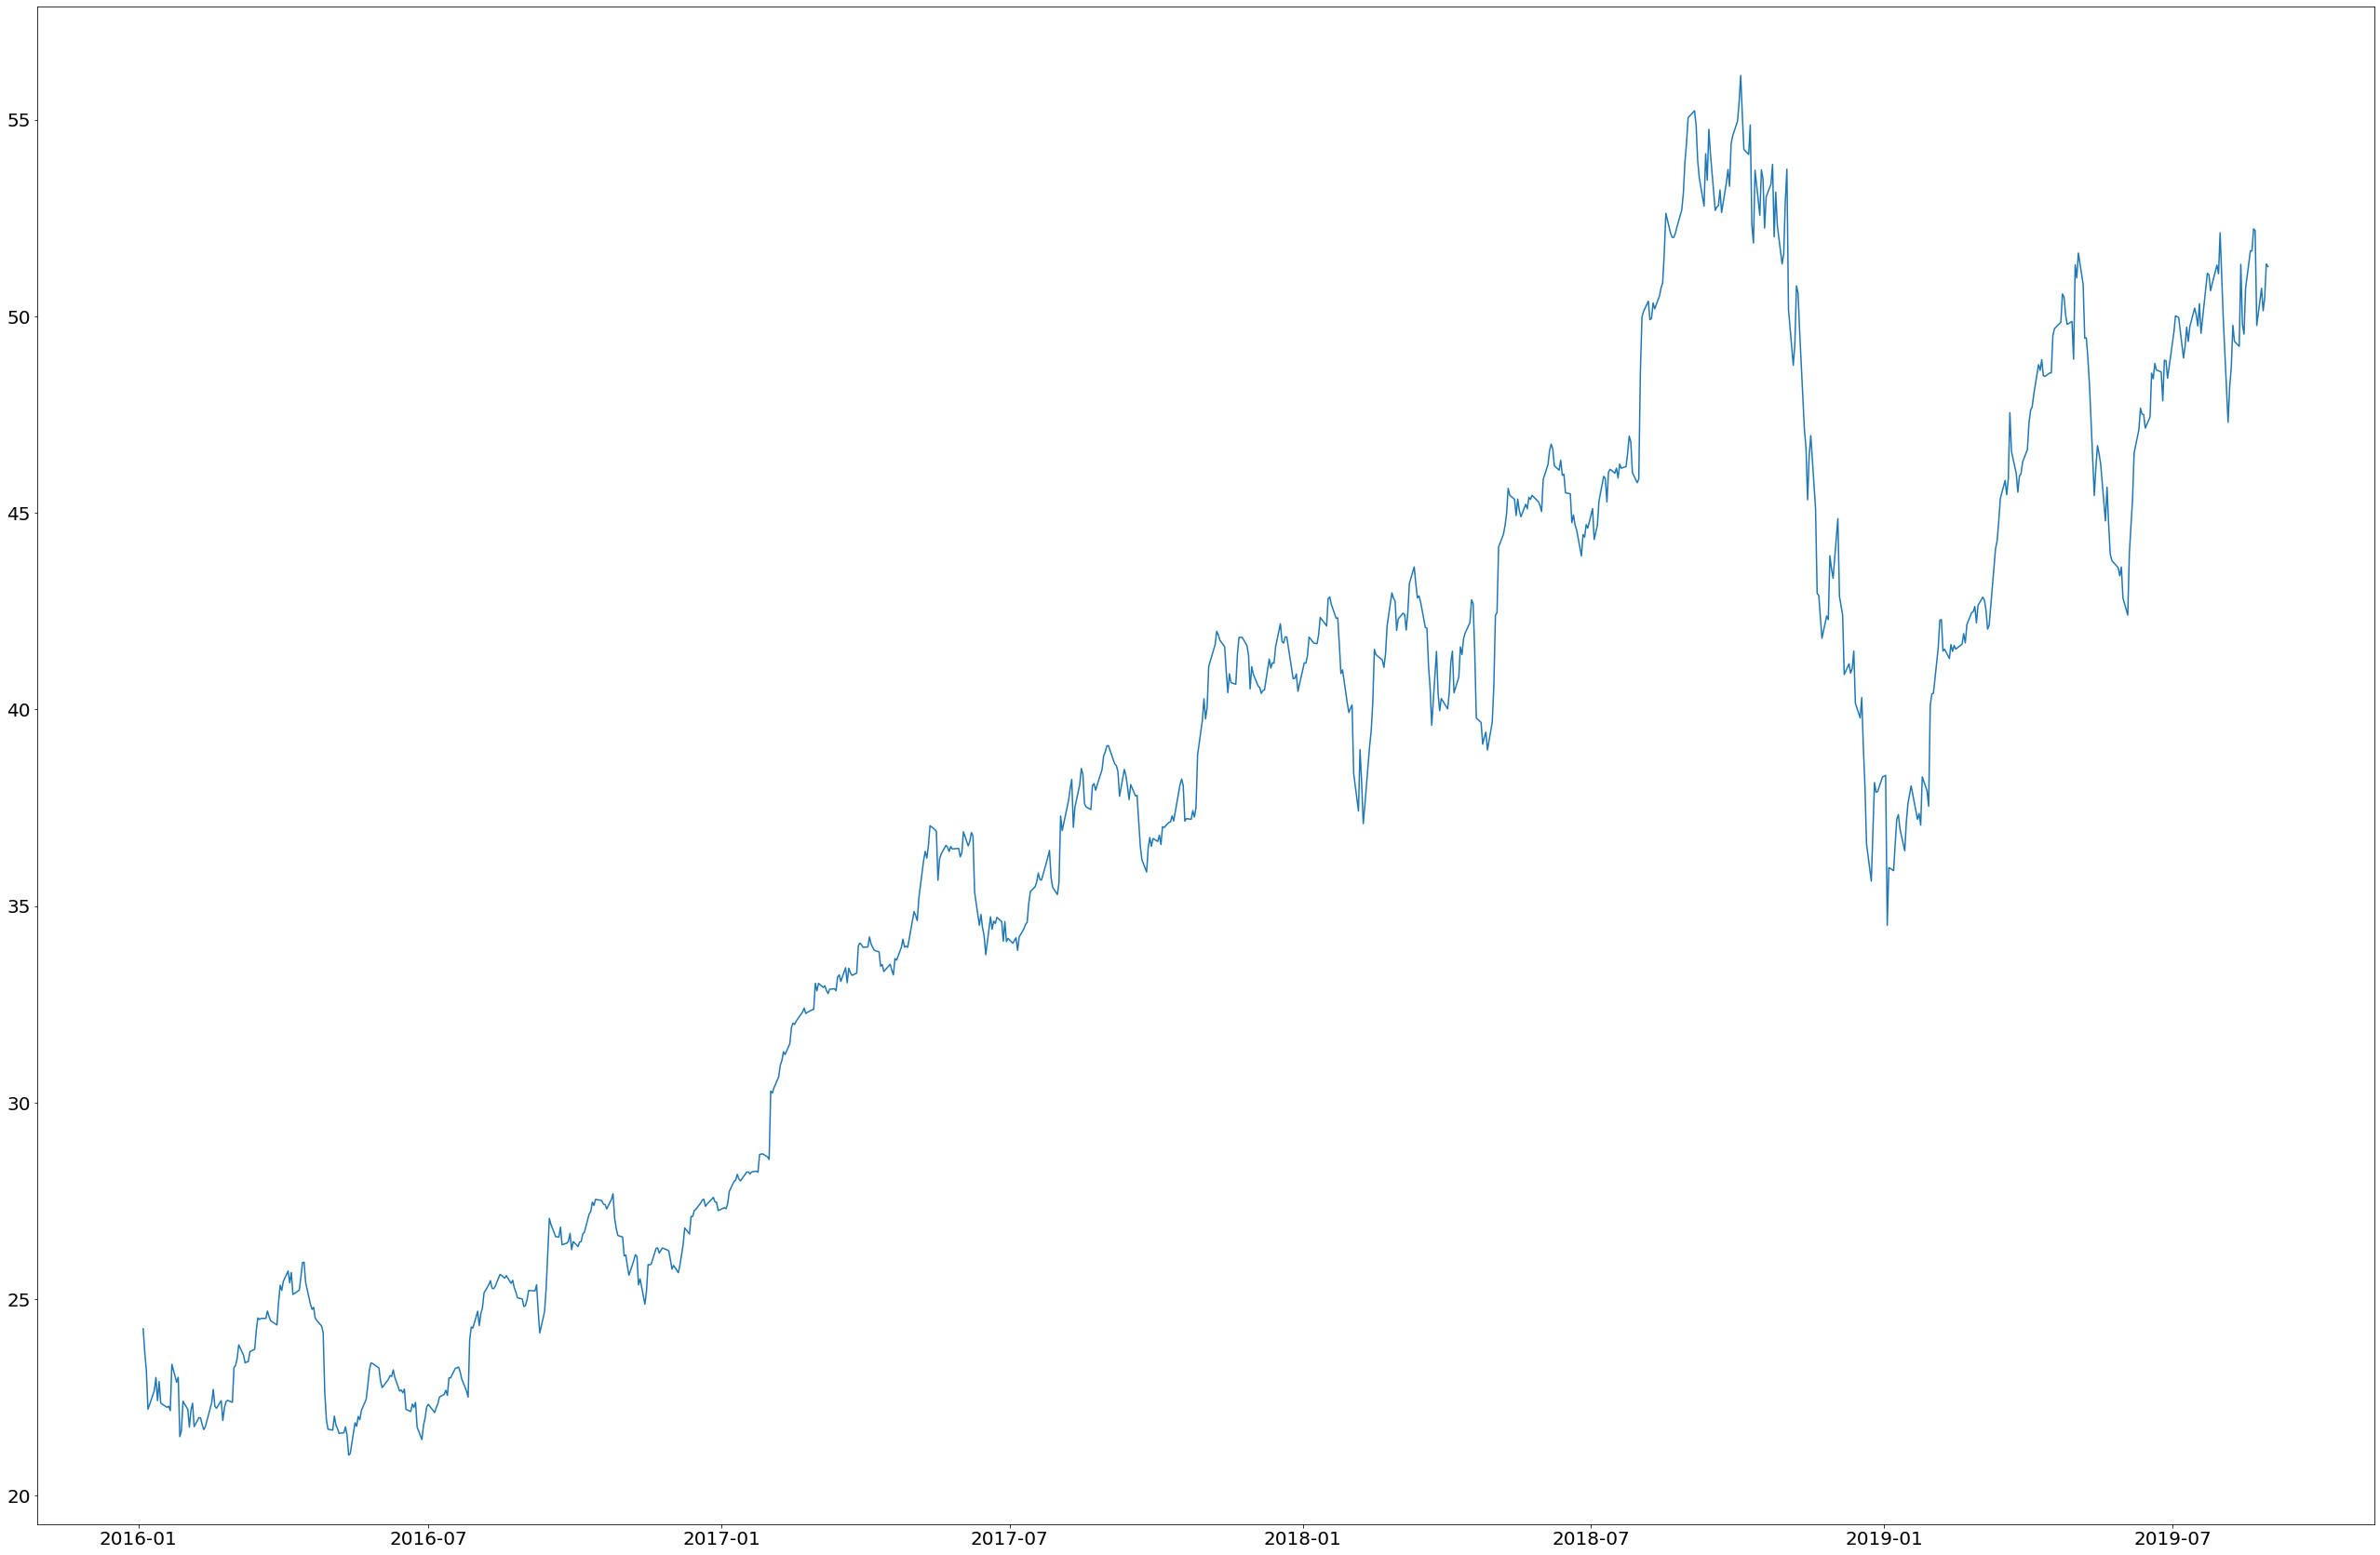

In [6]:
plt.plot(appl['Close'])

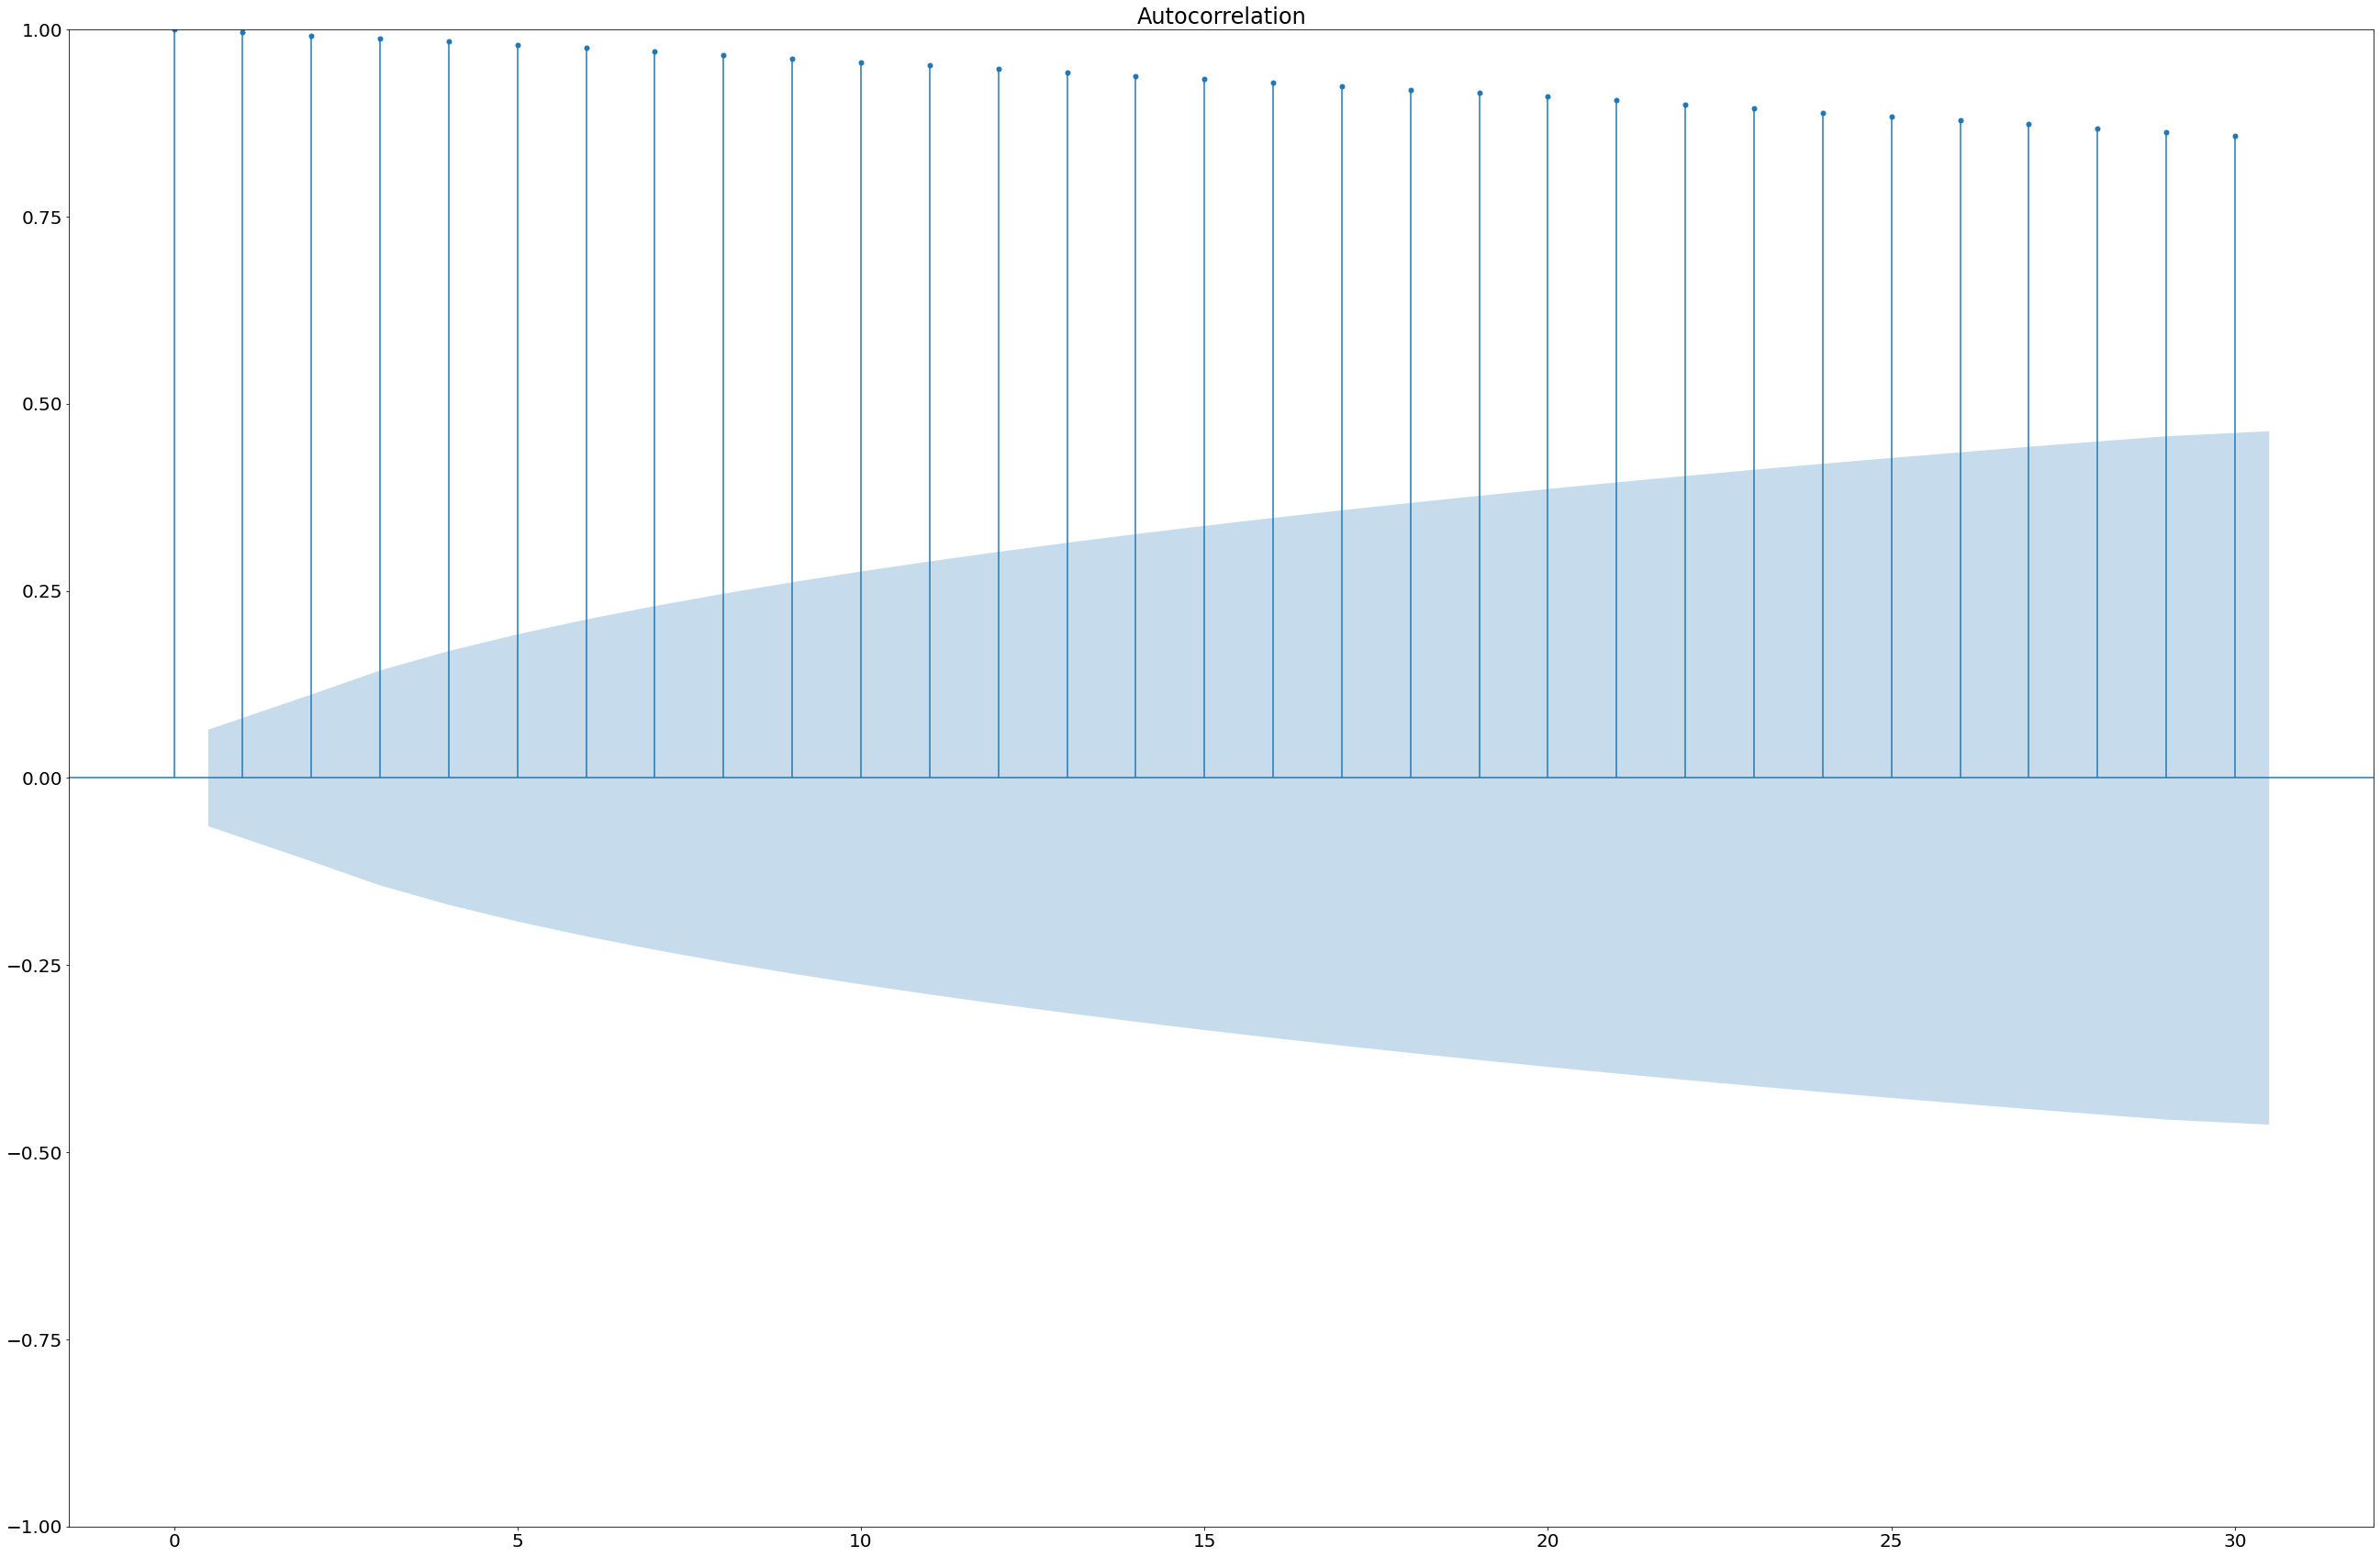

In [7]:
plot_acf(appl['Close']);

In [8]:
#there is some serial correlation between returns.

In [9]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(appl['Close'], autolag = 'AIC')
print("1. ADF: ", dftest[0])
print("2. P-value: ", dftest[1])
print("3. Num of Lags: ", dftest[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculations: ", dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t", key, val)

1. ADF:  -1.1377790376460986
2. P-value:  0.6997734208248161
3. Num of Lags:  9
4. Num of Observations used for ADF Regression and Critical Values Calculations:  912
5. Critical Values: 
	 1% -3.4375405714950604
	 5% -2.8647143318899913
	 10% -2.5684602193463375


In [10]:
#the data is non-stationary

In [11]:
#load tweet polarity data
appltweets = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-5.csv")

In [12]:
appltweets

,date,ts_polarity,twitter_volume
0,2016-01-01,0.119693,417
1,2016-01-02,0.140774,495
2,2016-01-03,0.181132,518
3,2016-01-04,0.070389,1133
4,2016-01-05,0.133635,1430
...,...,...,...
1336,2019-08-29,0.056460,1083
1337,2019-08-30,0.106096,1005
1338,2019-08-31,0.151625,224
1339,2019-09-01,0.059887,200


In [13]:
#need to rename data column so that I can merge it with the stock data
appltweets = appltweets.rename(columns={'date': 'Date'})

In [14]:
appltweets = appltweets.astype({'Date': 'datetime64[ns]'})

In [15]:
#merge tweet data
applfull = pd.merge(appl, appltweets, on = 'Date')
applfull = applfull.astype({'Date': 'datetime64[ns]'})
applnew = applfull.set_index('Date')
applnew

,Open,High,Low,Close,Volume,Dividends,Stock Splits,return,ts_polarity,twitter_volume
Date,,,,,,,,,,
2016-01-04,23.620694,24.256043,23.480273,24.251438,270597600,0.0,0,0.000000,0.070389,1133
2016-01-05,24.343515,24.366535,23.574653,23.643711,223164000,0.0,0,-0.607727,0.133635,1430
2016-01-06,23.148780,23.565441,22.989944,23.181007,273829600,0.0,0,-0.462704,0.072042,1949
2016-01-07,22.716013,23.049801,22.198066,22.202669,324377600,0.0,0,-0.978338,0.074369,2289
2016-01-08,22.686083,22.814994,22.274027,22.320066,283192000,0.0,0,0.117397,0.051595,2235
...,...,...,...,...,...,...,...,...,...,...
2019-08-26,50.559933,50.886586,50.363450,50.714664,104174400,0.0,0,0.945580,0.072340,888
2019-08-27,51.051135,51.220602,49.987671,50.142403,103493200,0.0,0,-0.572262,0.117541,962
2019-08-28,50.127667,50.525543,49.936096,50.478878,63755200,0.0,0,0.336475,0.061477,895


In [16]:
applnew.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='Date', length=922, freq=None)

In [17]:
#index the data by date
applnew['Date'] = pd.to_datetime(applnew.index)
applnew['Date'] = applnew['Date'].apply(mpl_dates.date2num)

applnew = applnew.loc[:,['Date', 'Close','return','Volume', 'ts_polarity', 'twitter_volume']]
appl = applnew

In [18]:
appl = appl.replace(np.nan, 0)

In [19]:
appl

,Date,Close,return,Volume,ts_polarity,twitter_volume
Date,,,,,,
2016-01-04,16804.0,24.251438,0.000000,270597600,0.070389,1133
2016-01-05,16805.0,23.643711,-0.607727,223164000,0.133635,1430
2016-01-06,16806.0,23.181007,-0.462704,273829600,0.072042,1949
2016-01-07,16807.0,22.202669,-0.978338,324377600,0.074369,2289
2016-01-08,16808.0,22.320066,0.117397,283192000,0.051595,2235
...,...,...,...,...,...,...
2019-08-26,18134.0,50.714664,0.945580,104174400,0.072340,888
2019-08-27,18135.0,50.142403,-0.572262,103493200,0.117541,962
2019-08-28,18136.0,50.478878,0.336475,63755200,0.061477,895


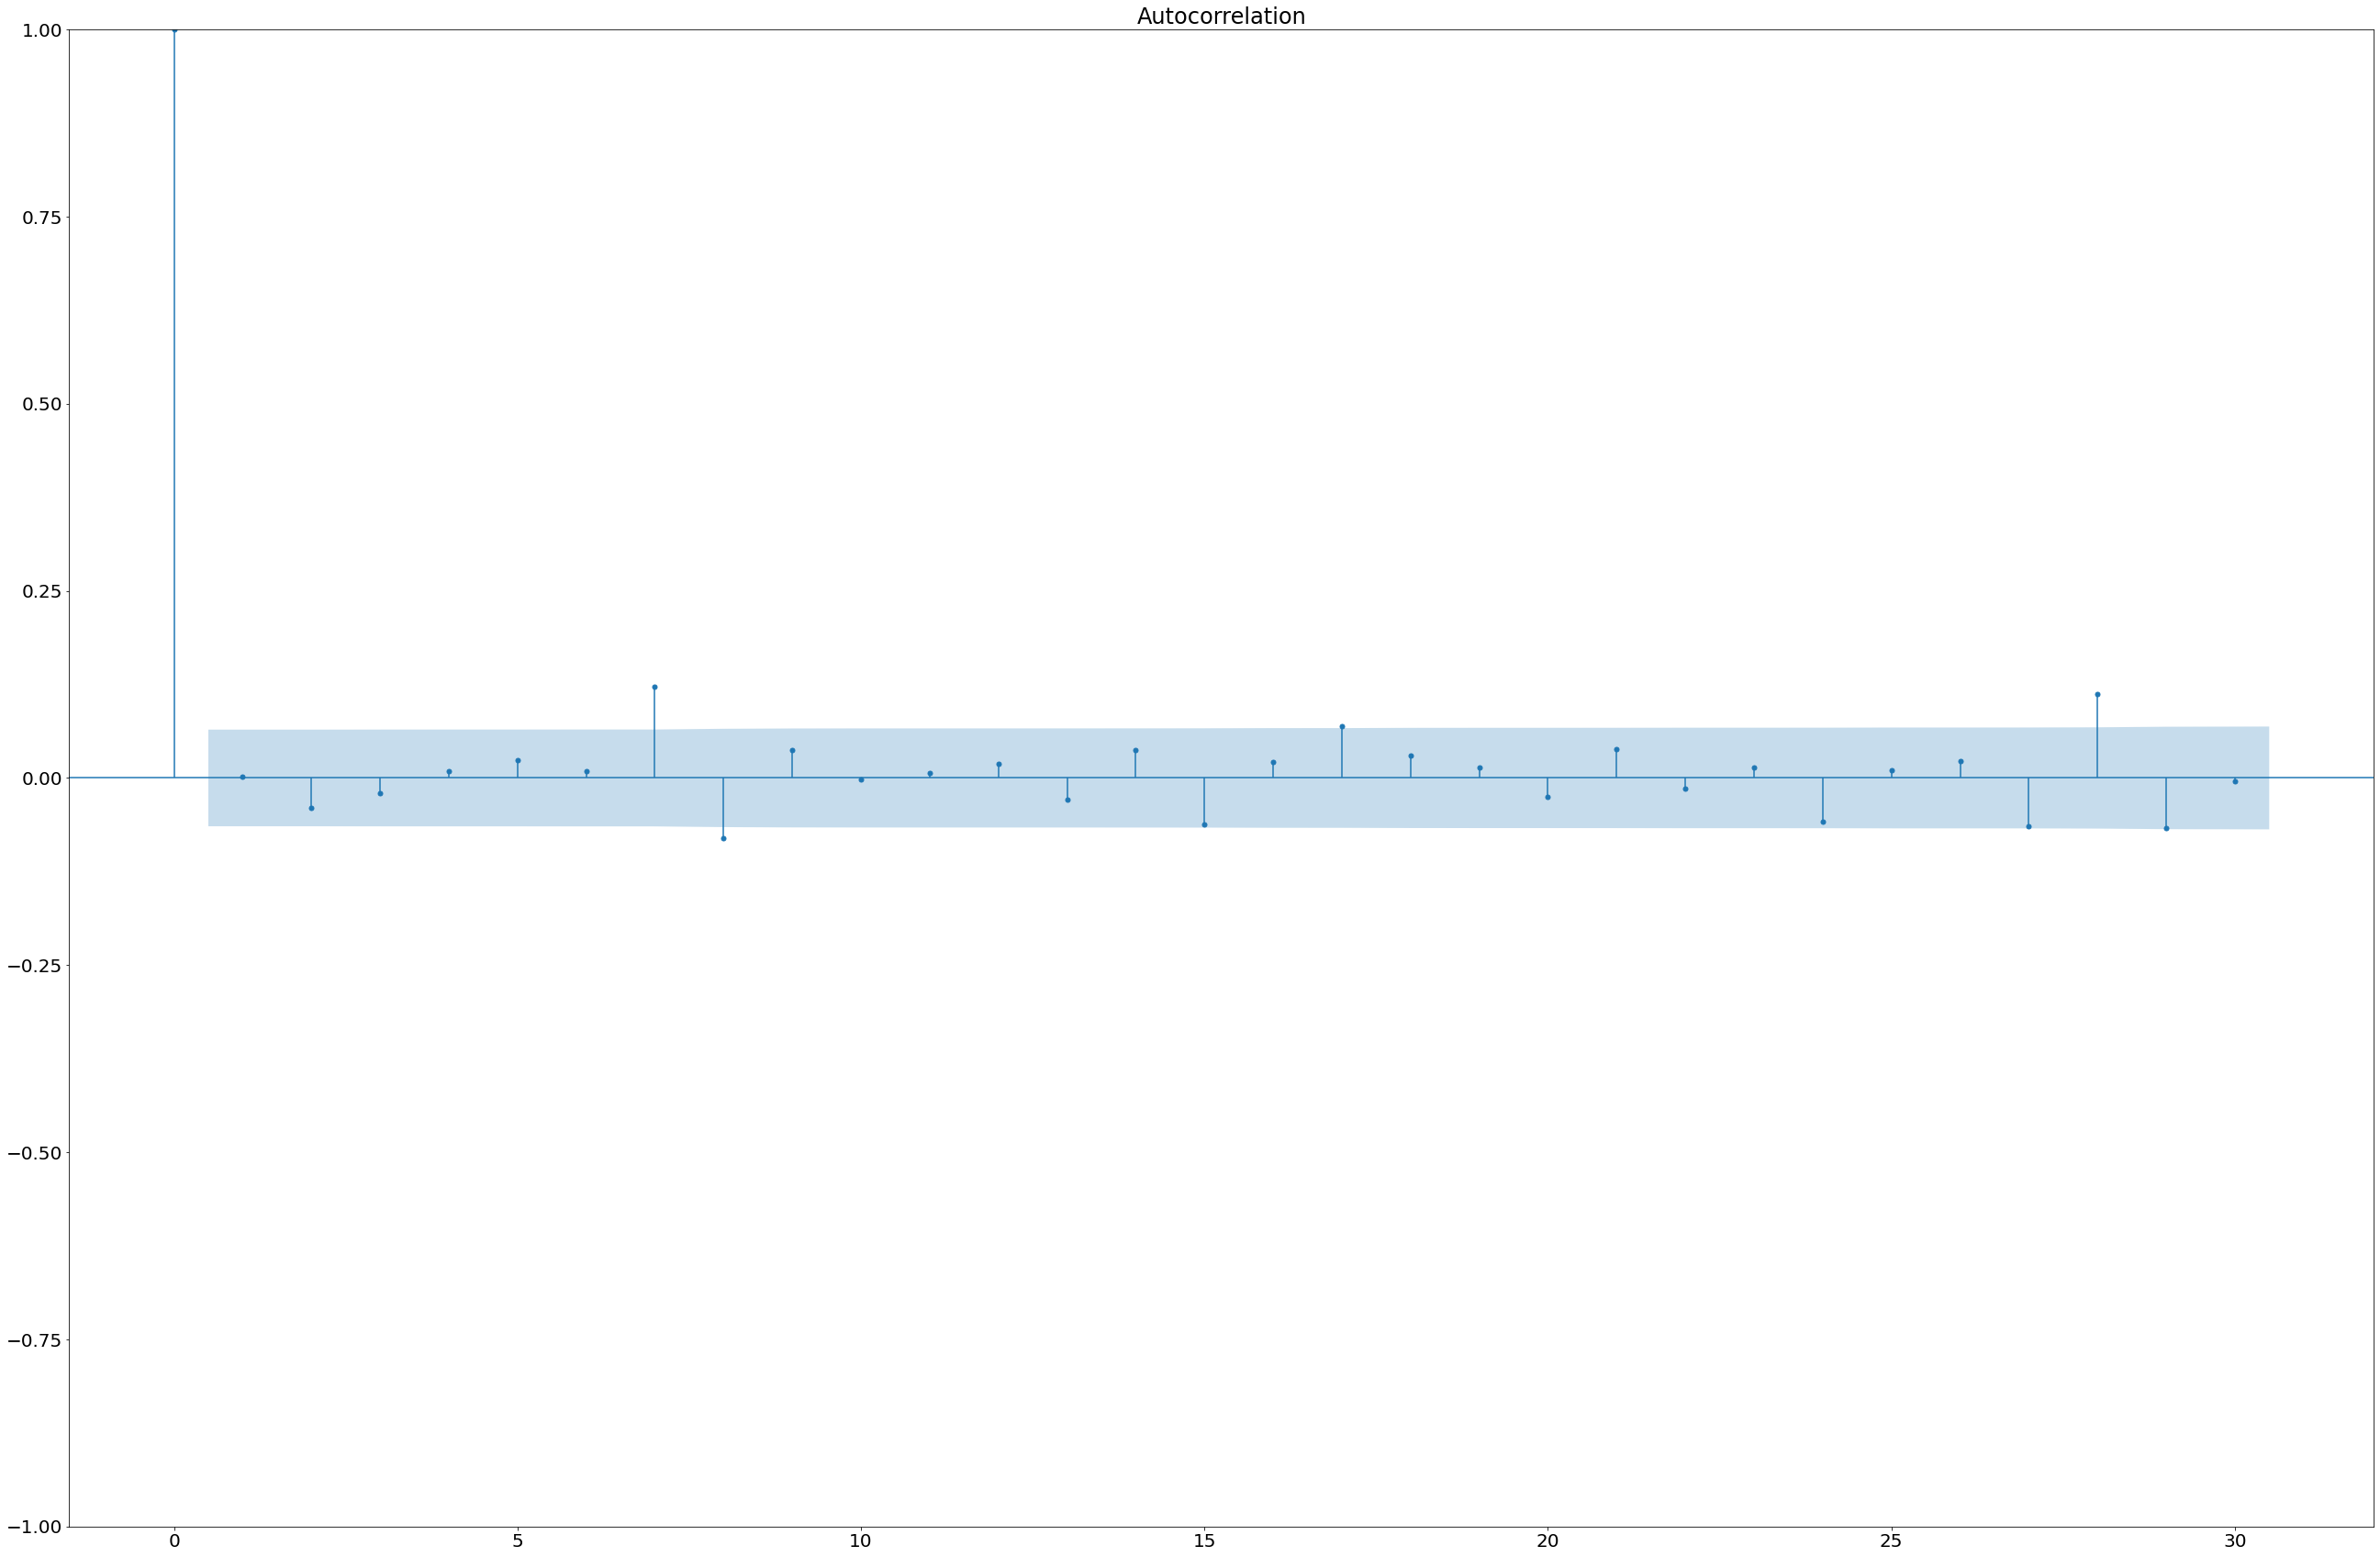

In [20]:
plot_acf(appl['return']);

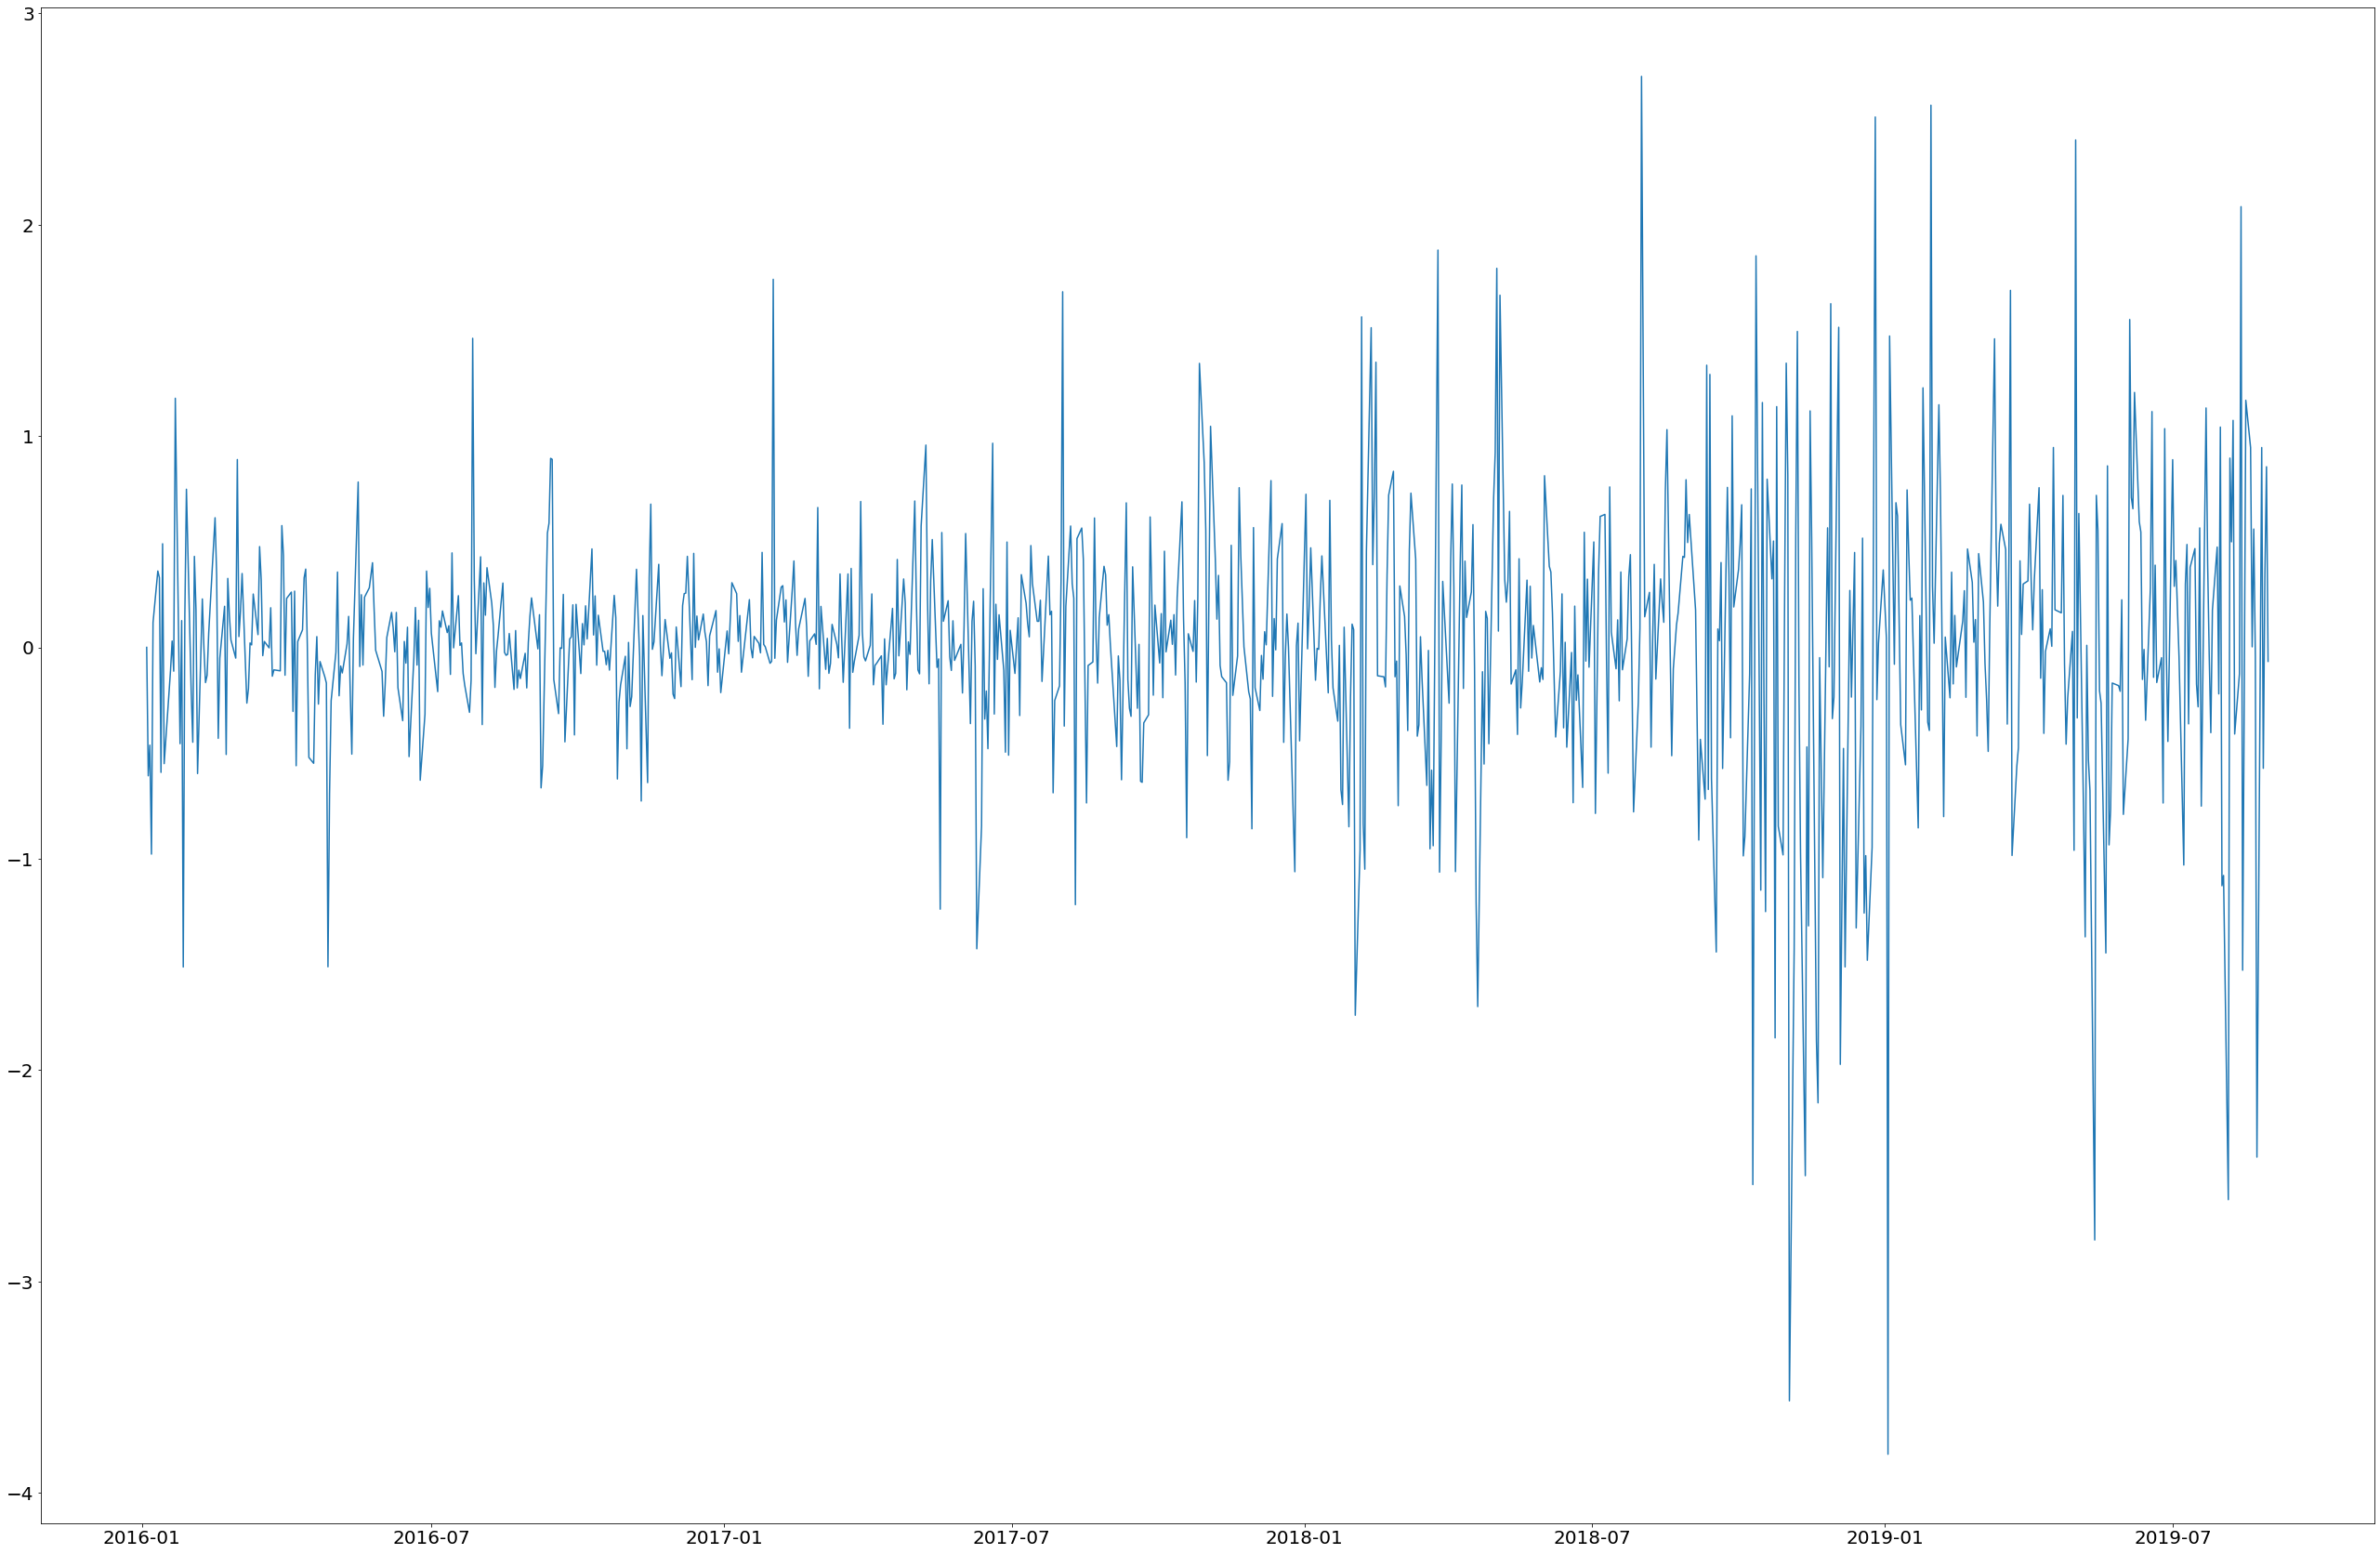

In [21]:
plt.plot(appl['return'])

# Check for ideal model

In [22]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [23]:
ideal_fit = auto_arima(appl['return'], trace=True, supress_warnings=True)
ideal_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1728.260, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1730.259, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1730.259, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1728.342, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1731.980, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.581 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  922
Model:                        SARIMAX   Log Likelihood                -862.130
Date:                Fri, 10 Dec 2021   AIC                           1728.260
Time:                        00:36:41   BIC                           1737.913
Sample:                             0   HQIC                          1731.944
                                - 922                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0293      0.021      1.410      0.159      -0.011       0.070
sigma2         0.3799      0.009     41.380      0.000       0.362       0.398
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1340.46
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               6.62   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#the model described above assumes that a model with just white noise is ideal. Looking at the plots for my data
#I dont believe this to be true due to the volatility shown 

# MODEL 1 - ARIMAX model order (0,1,0)

In [25]:
print(appl.shape)
train = appl.iloc[:-30]
test = appl.iloc[-30:]
print(train.shape, test.shape)

(922, 6)
(892, 6) (30, 6)


In [26]:
train.dtypes

Date              float64
Close             float64
return            float64
Volume              int64
ts_polarity       float64
twitter_volume      int64
dtype: object

In [27]:
train

,Date,Close,return,Volume,ts_polarity,twitter_volume
Date,,,,,,
2016-01-04,16804.0,24.251438,0.000000,270597600,0.070389,1133
2016-01-05,16805.0,23.643711,-0.607727,223164000,0.133635,1430
2016-01-06,16806.0,23.181007,-0.462704,273829600,0.072042,1949
2016-01-07,16807.0,22.202669,-0.978338,324377600,0.074369,2289
2016-01-08,16808.0,22.320066,0.117397,283192000,0.051595,2235
...,...,...,...,...,...,...
2019-07-15,18092.0,50.209522,0.467327,67789600,0.161794,490
2019-07-16,18093.0,50.035797,-0.173725,67467200,0.142708,676
2019-07-17,18094.0,49.754429,-0.281368,56430000,0.128261,633


In [28]:
dif=test['Close'].diff()
dif = dif.replace(np.nan, 0)

In [29]:
import pyflux as pf
model = pf.ARIMAX(appl, formula='Close~ts_polarity', ma=0, ar=0, integ=1,
              family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(0,1,0)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Close                   Method: MLE                                       
Start Date: 2016-01-04 00:00:00                         Log Likelihood: -860.3551                         
End Date: 2019-08-30 00:00:00                           AIC: 1726.7102                                    
Number of observations: 921                             BIC: 1741.1866                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Beta 1                                   -0.0402    0.0471     -0.8547  0.3927   (-0.1325 | 0.0521)       
Beta ts_polarity                     

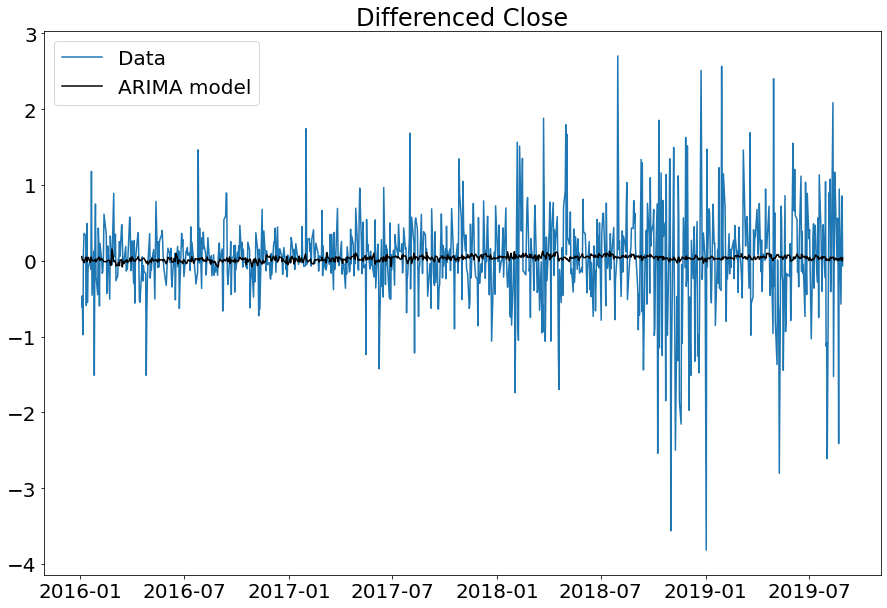

In [30]:
model.plot_fit(figsize=(15,10))

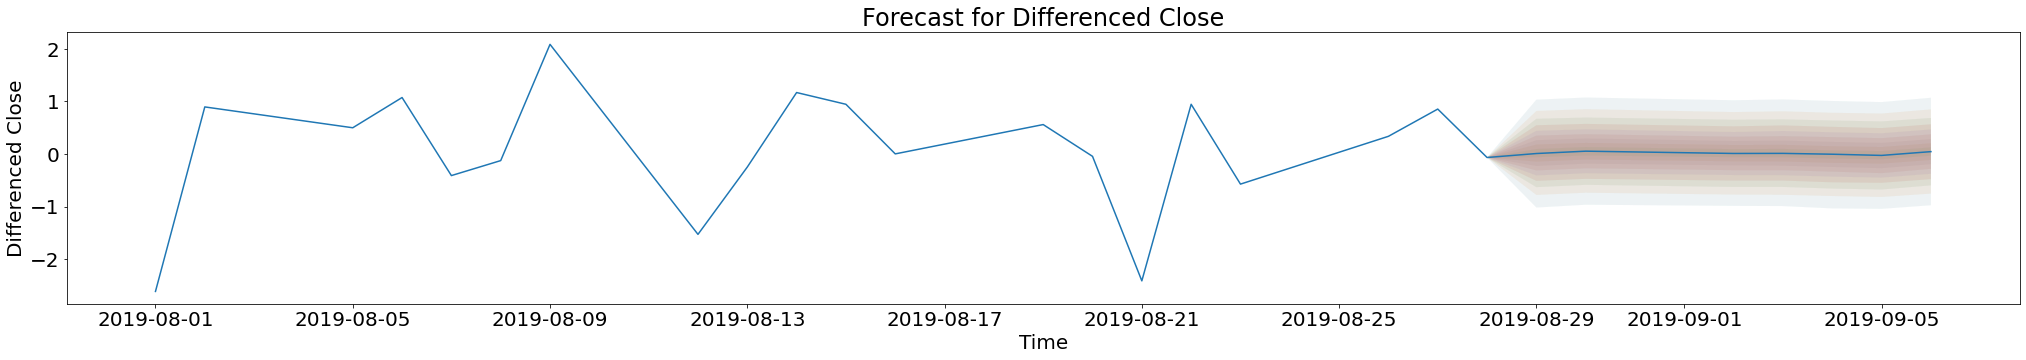

In [31]:
model.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [32]:
model_est=model.predict(h=7, oos_data=appl,)
model_est

,Differenced Close
Date,
2019-08-29,0.009415
2019-08-30,0.054039
2019-09-02,0.010581
2019-09-03,0.012224
2019-09-04,-0.003846
2019-09-05,-0.026531
2019-09-06,0.045381


In [33]:
model_est.values

array([[ 0.00941495],
       [ 0.05403949],
       [ 0.01058137],
       [ 0.01222362],
       [-0.00384555],
       [-0.02653073],
       [ 0.04538128]])

In [34]:
model_est = np.delete(model_est.values, [2])
model_est

array([ 0.00941495,  0.05403949,  0.01222362, -0.00384555, -0.02653073,
        0.04538128])

In [35]:
futureobs = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-13.csv")

In [36]:
futureobs = futureobs.set_index('Date')

In [37]:
futureobs['AdjClose'] = futureobs['Adj Close']
dif=futureobs['AdjClose'].diff()
dif = dif.replace(np.nan, 0)

In [38]:
dif = pd.DataFrame(dif)

In [39]:
dif

,AdjClose
Date,
2019-08-29,0.000000
2019-08-30,-0.066303
2019-09-03,-0.746639
2019-09-04,0.857155
2019-09-05,1.004524
2019-09-06,-0.004917


In [40]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import r2_score
print('Mean Squared Error:', (mean_squared_error(dif, model_est)))
print('R-squared :', r2_score(dif, model_est))

Mean Squared Error: 0.3995615232812951
R-squared : -0.1286624336027169


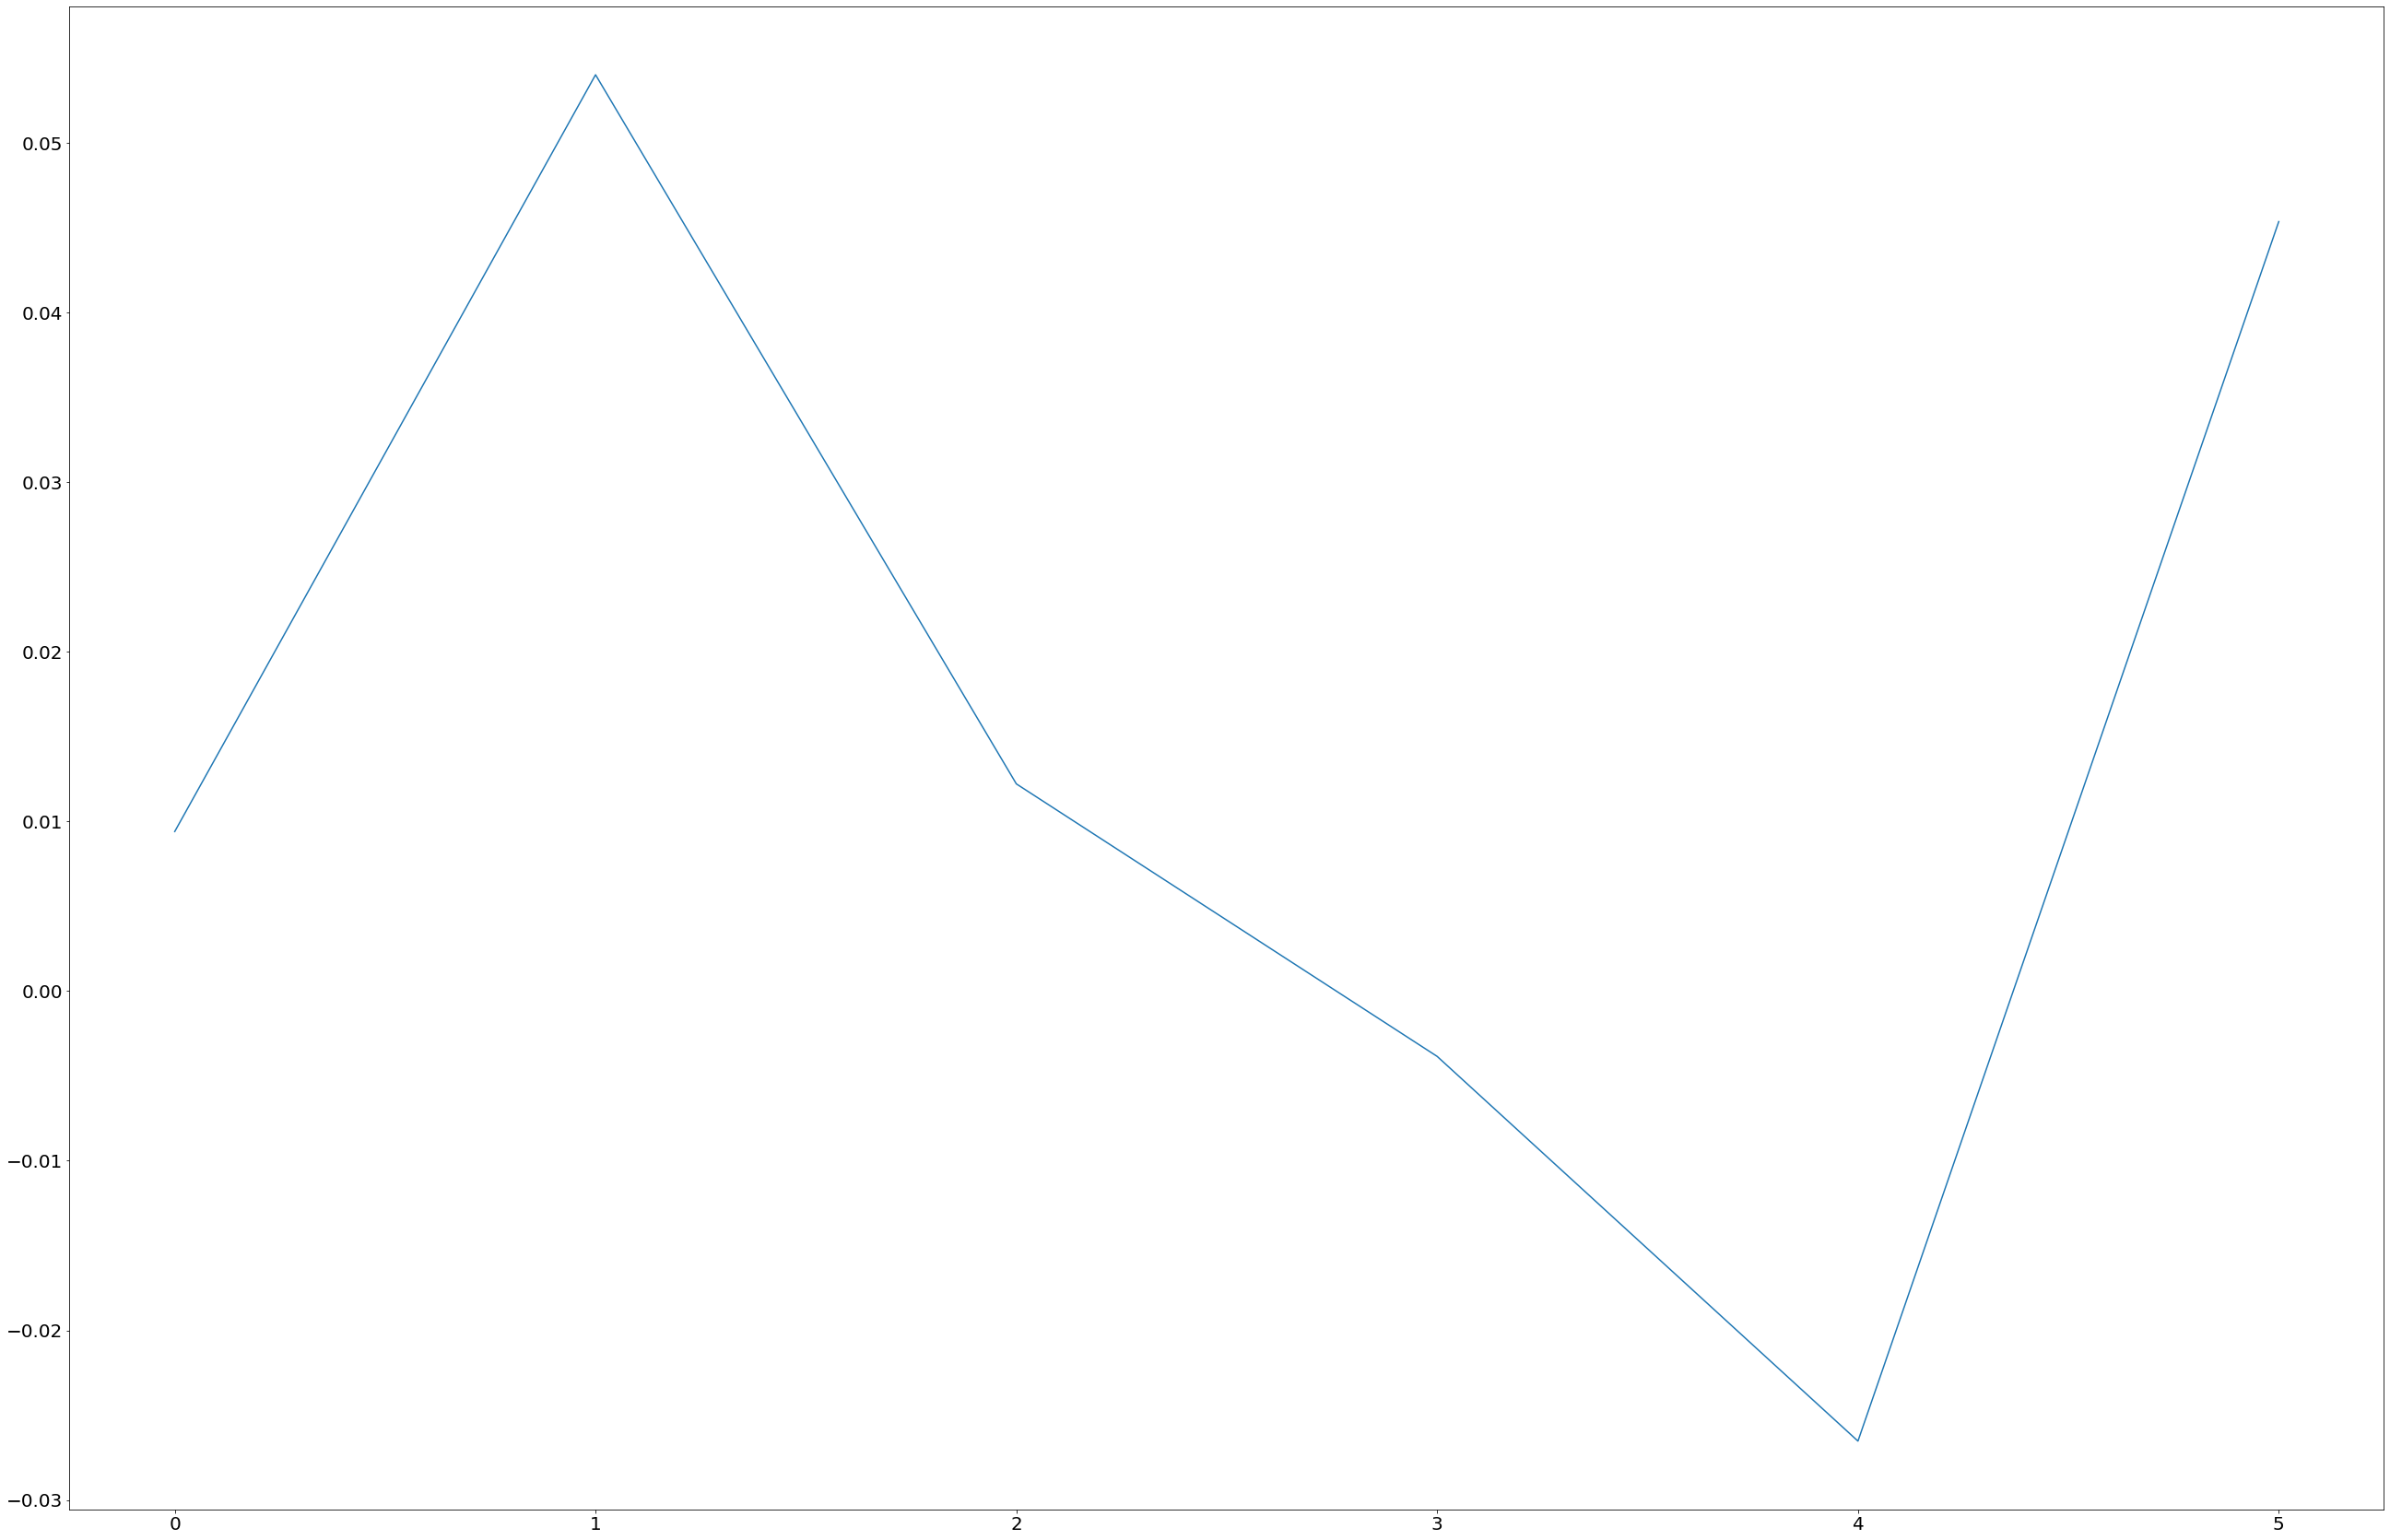

In [41]:
plt.plot(model_est, label = 'forecast')

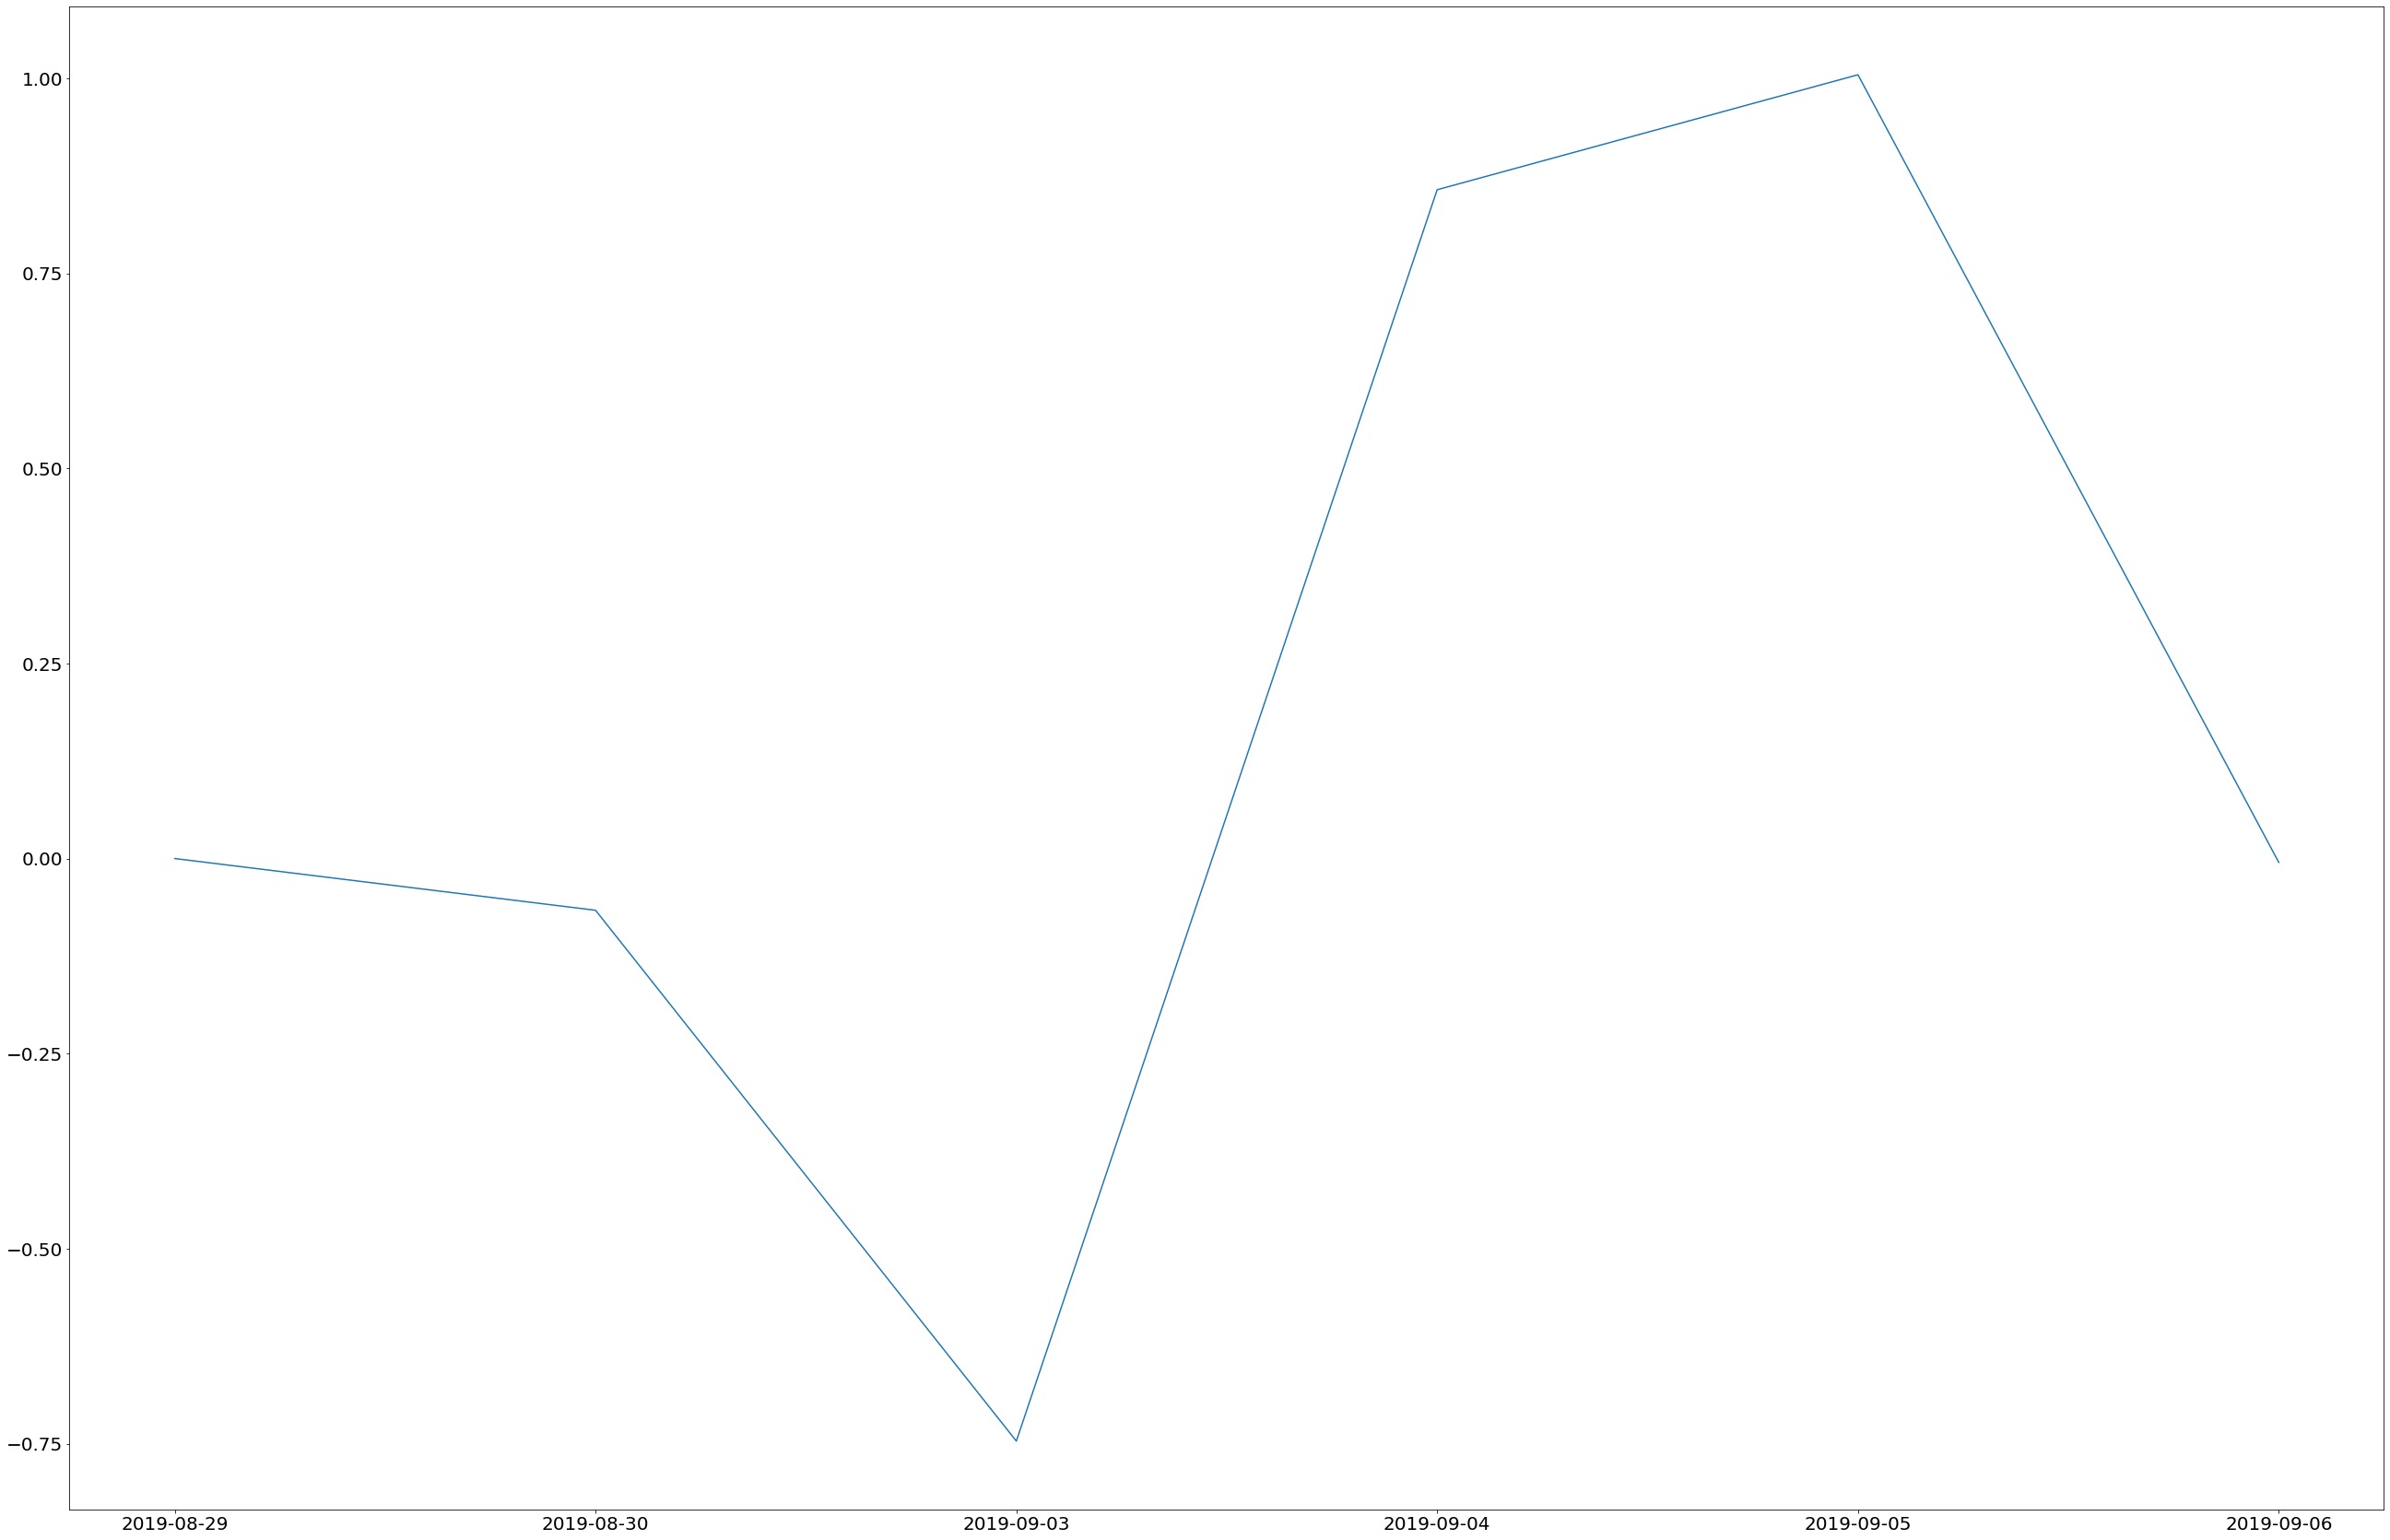

In [42]:
plt.plot(dif, label='actual')

# MODEL 2 - ARIMAX model order (1,1,1)

In [43]:
model2 = pf.ARIMAX(appl, formula='Close~ts_polarity', ma=1, ar=1, integ=1,
              family=pf.Normal())
x2 = model2.fit("MLE")
x2.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Close                   Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: -859.3429                         
End Date: 2019-08-30 00:00:00                           AIC: 1728.6858                                    
Number of observations: 920                             BIC: 1752.8077                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0667     0.8994     0.0742   0.9408   (-1.696 | 1.8295)        
MA(1)                                

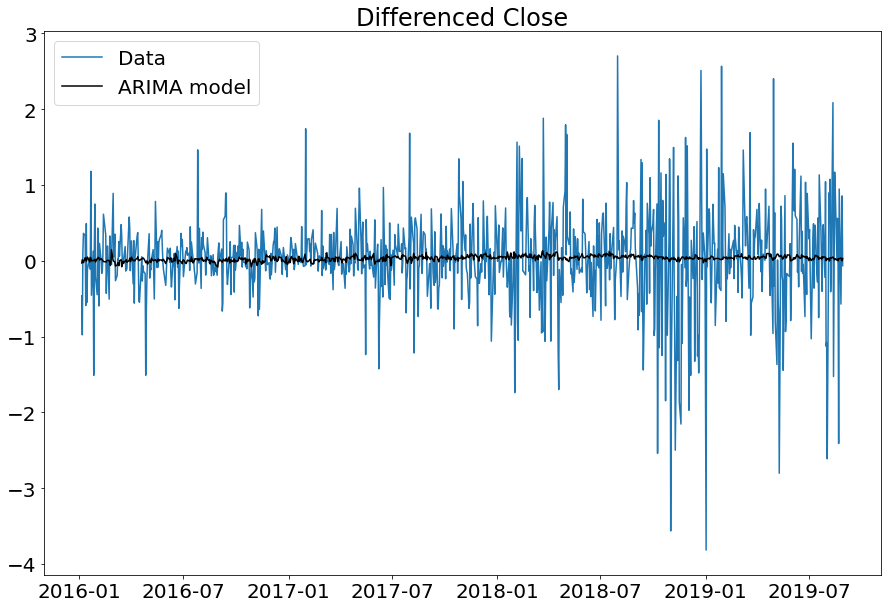

In [44]:
model2.plot_fit(figsize=(15,10))

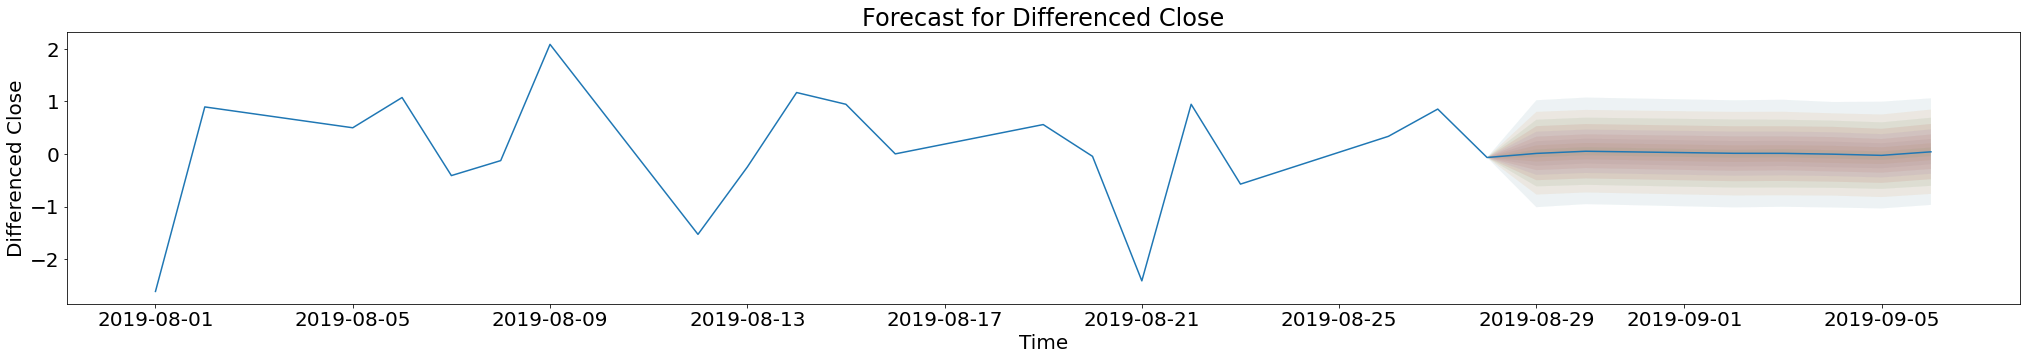

In [45]:
model2.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [46]:
model2_est=model2.predict(h=7, oos_data=appl,)
model2_est 

,Differenced Close
Date,
2019-08-29,0.011538
2019-08-30,0.052500
2019-09-02,0.013723
2019-09-03,0.012704
2019-09-04,-0.002713
2019-09-05,-0.025410
2019-09-06,0.041764


In [47]:
model2_est.values

array([[ 0.0115376 ],
       [ 0.05249976],
       [ 0.01372329],
       [ 0.01270392],
       [-0.00271307],
       [-0.02541046],
       [ 0.04176363]])

In [48]:
model2_est = np.delete(model2_est.values, [2])

In [49]:
model2_est

array([ 0.0115376 ,  0.05249976,  0.01270392, -0.00271307, -0.02541046,
        0.04176363])

In [50]:
print('Mean Squared Error:', (mean_squared_error(dif, model2_est)))
print('R-squared :', r2_score(dif, model2_est))

Mean Squared Error: 0.3988610093840114
R-squared : -0.12668365518184244


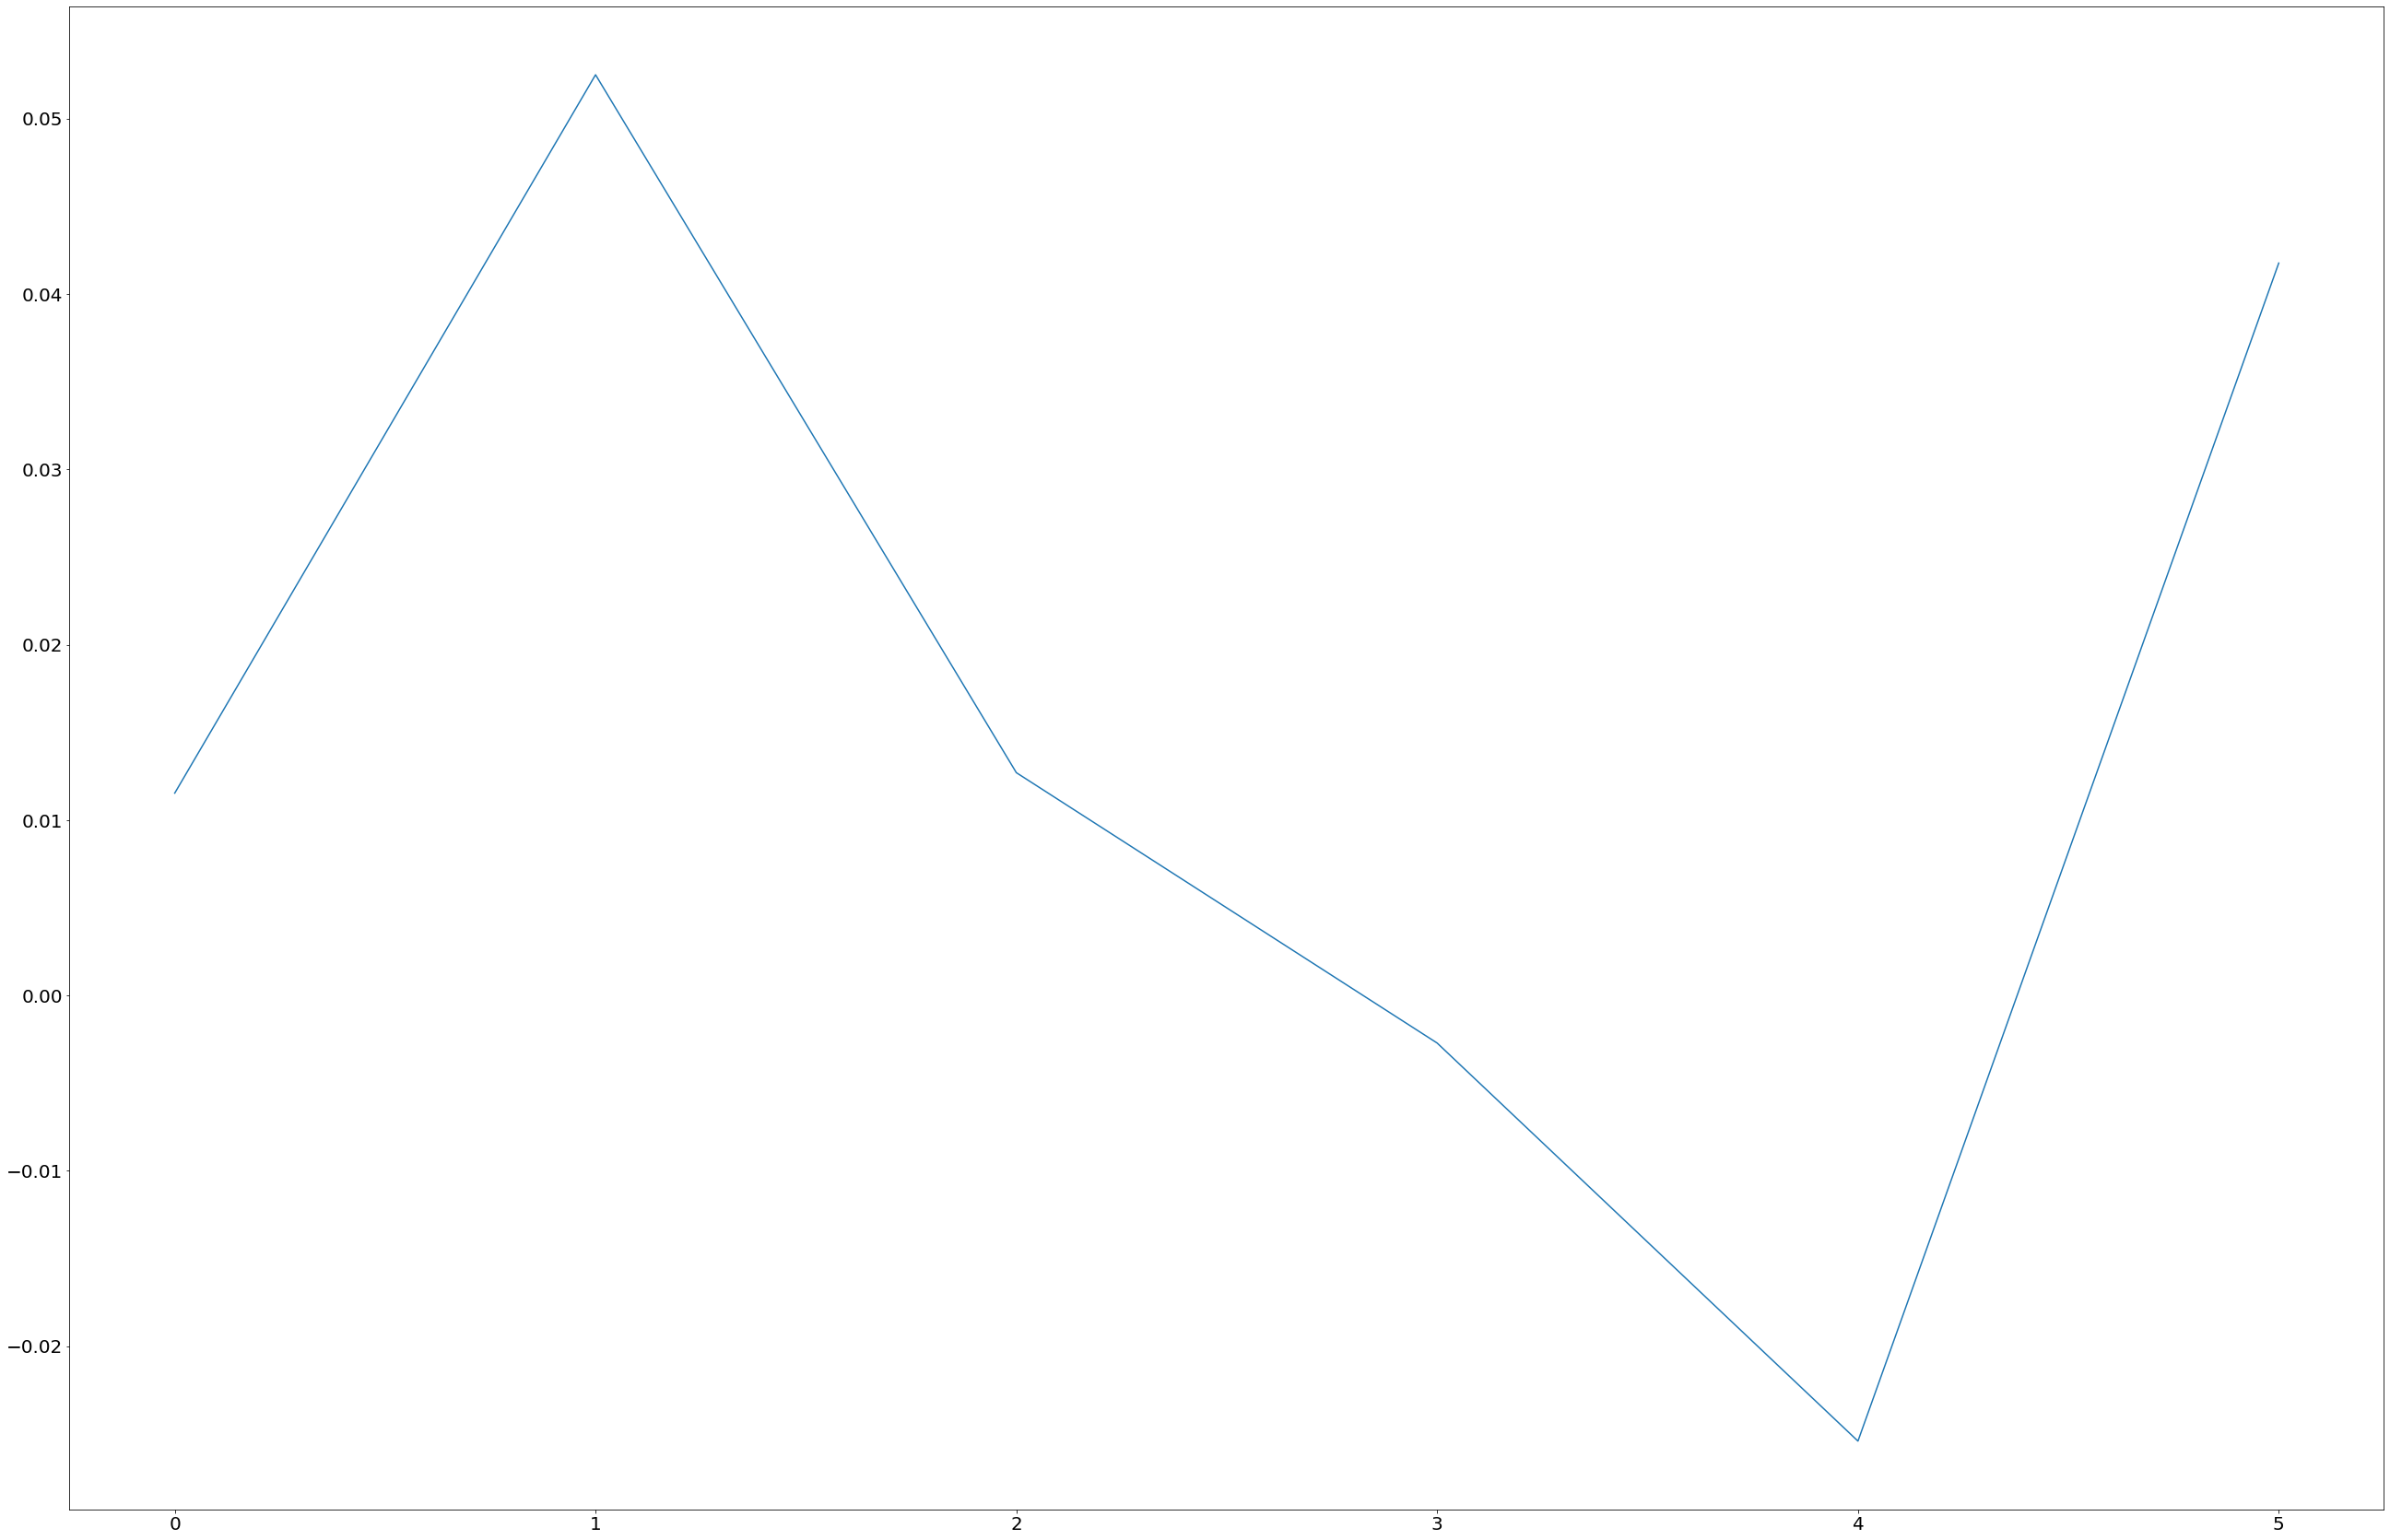

In [51]:
plt.plot(model2_est, label = 'forecast')

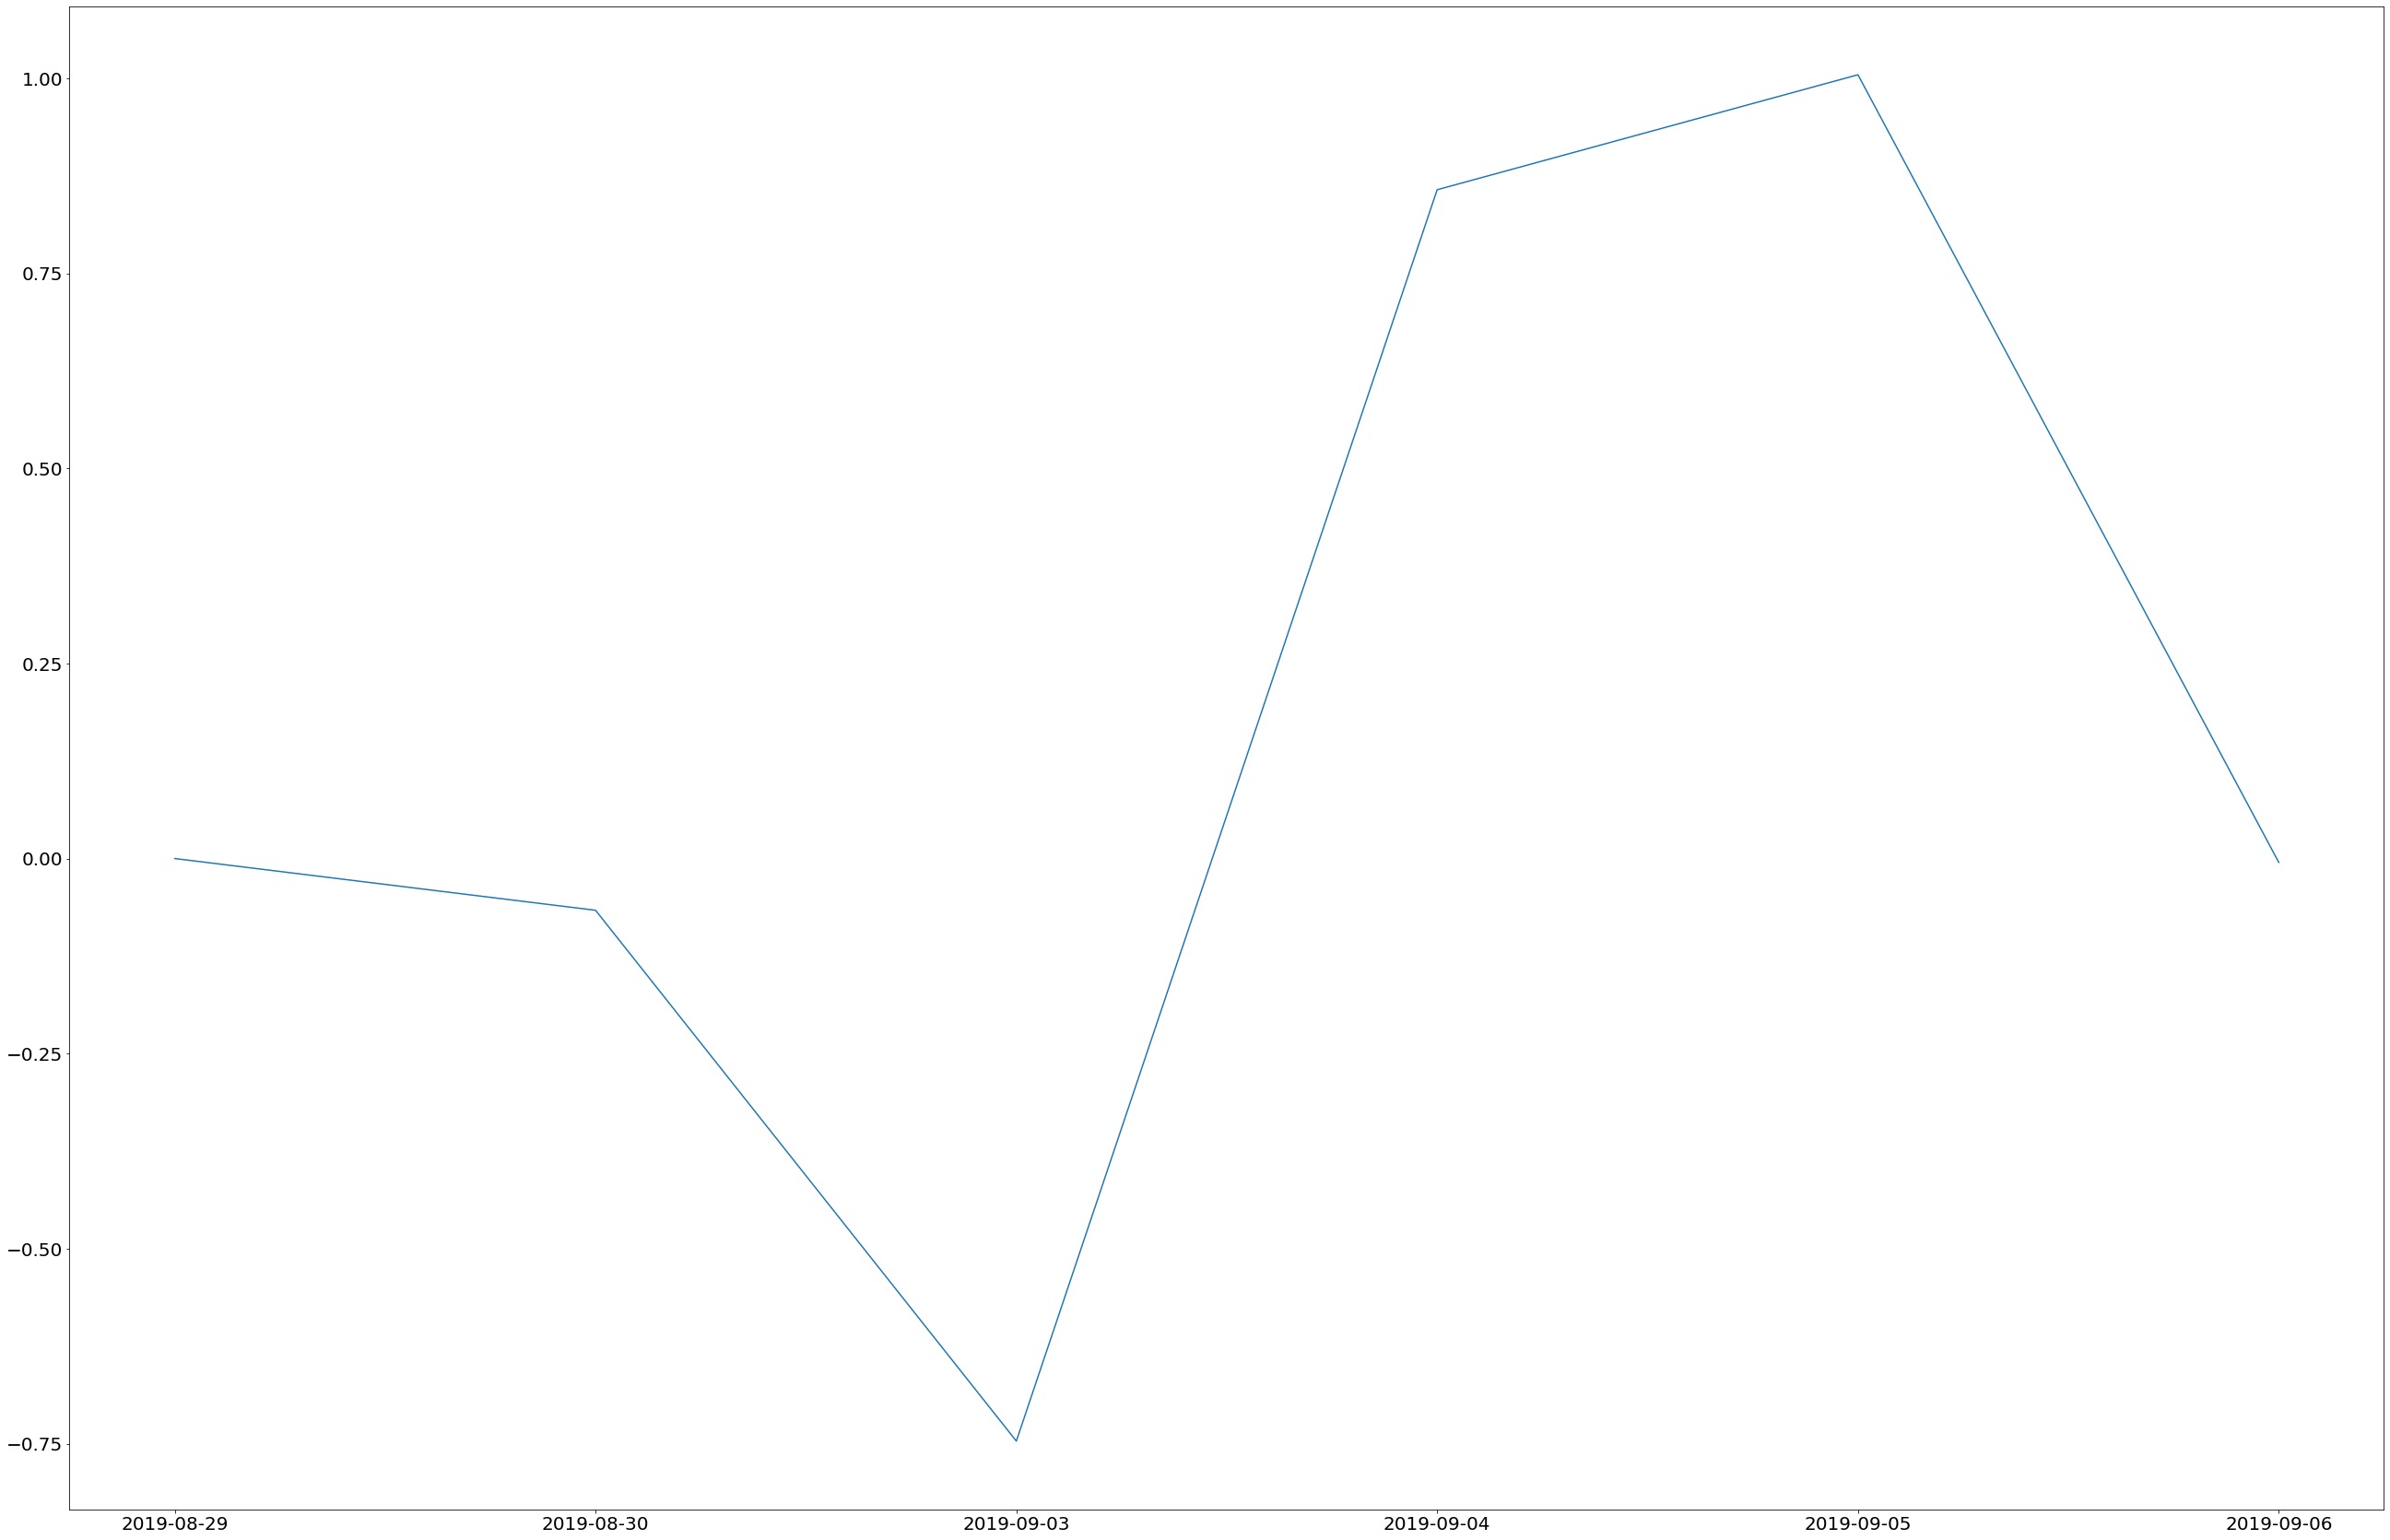

In [52]:
plt.plot(dif, label='actual')

# MODEL 3 - ARIMAX model order (2,1,2)

In [53]:
model3 = pf.ARIMAX(appl, formula='Close~ts_polarity', ma=2, ar=2, integ=1,
              family=pf.Normal())
x3 = model3.fit("MLE")
x3.summary()

Normal ARIMAX(2,1,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced Close                   Method: MLE                                       
Start Date: 2016-01-06 00:00:00                         Log Likelihood: -857.7181                         
End Date: 2019-08-30 00:00:00                           AIC: 1729.4363                                    
Number of observations: 919                             BIC: 1763.1993                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1456     0.4429     0.3288   0.7423   (-0.7225 | 1.0137)       
AR(2)                                

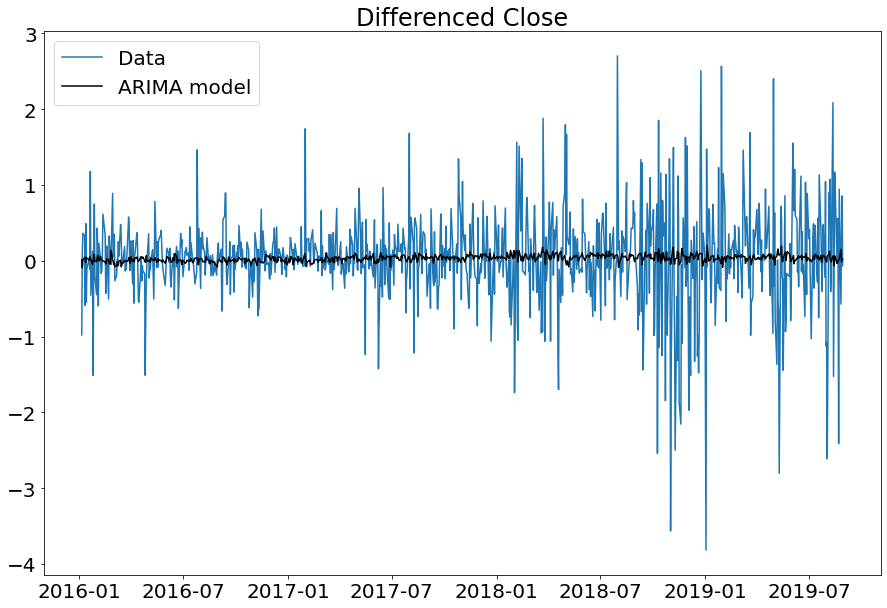

In [54]:
model3.plot_fit(figsize=(15,10))

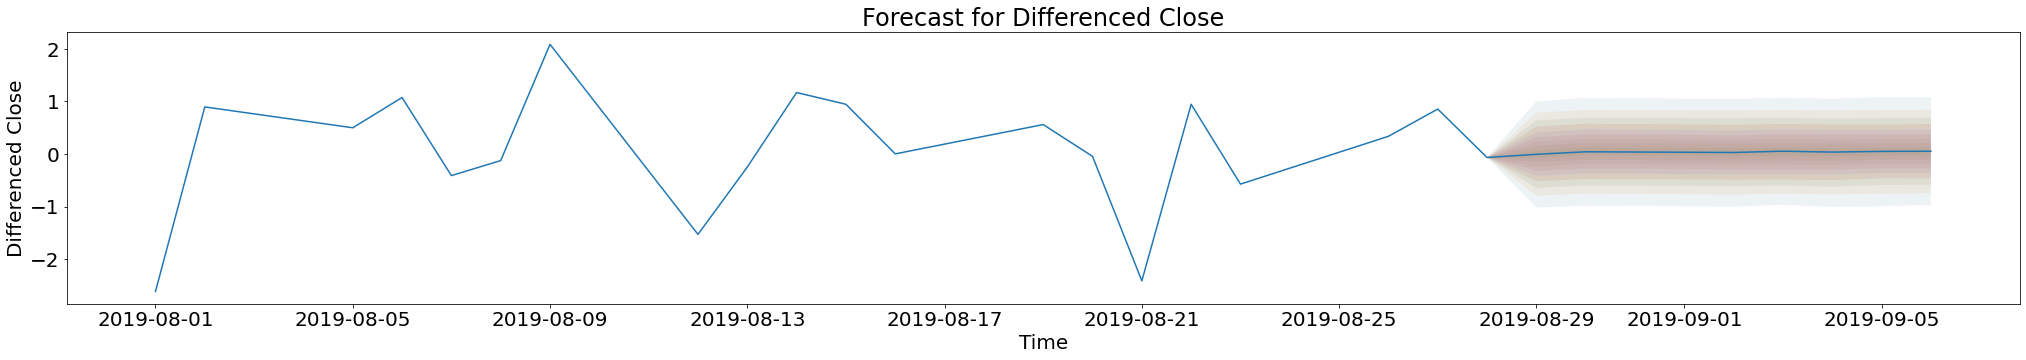

In [55]:
model3.plot_predict(h=7, oos_data=test, figsize=(35,5))

In [56]:
model3_est=model3.predict(h=7, oos_data=appl,)
model3_est 

,Differenced Close
Date,
2019-08-29,-0.025303
2019-08-30,0.051040
2019-09-02,0.021923
2019-09-03,0.011006
2019-09-04,-0.002684
2019-09-05,-0.025016
2019-09-06,0.041414


In [57]:
model3_est.values

array([[-0.02530267],
       [ 0.05104042],
       [ 0.02192282],
       [ 0.01100602],
       [-0.0026842 ],
       [-0.02501648],
       [ 0.04141433]])

In [58]:
model3_est = np.delete(model3_est.values, [2])

In [59]:
model3_est

array([-0.02530267,  0.05104042,  0.01100602, -0.0026842 , -0.02501648,
        0.04141433])

In [60]:
print('Mean Squared Error:', (mean_squared_error(dif, model3_est)))
print('R-squared :', r2_score(dif, model3_est))

Mean Squared Error: 0.3983098853822024
R-squared : -0.12512686624983949


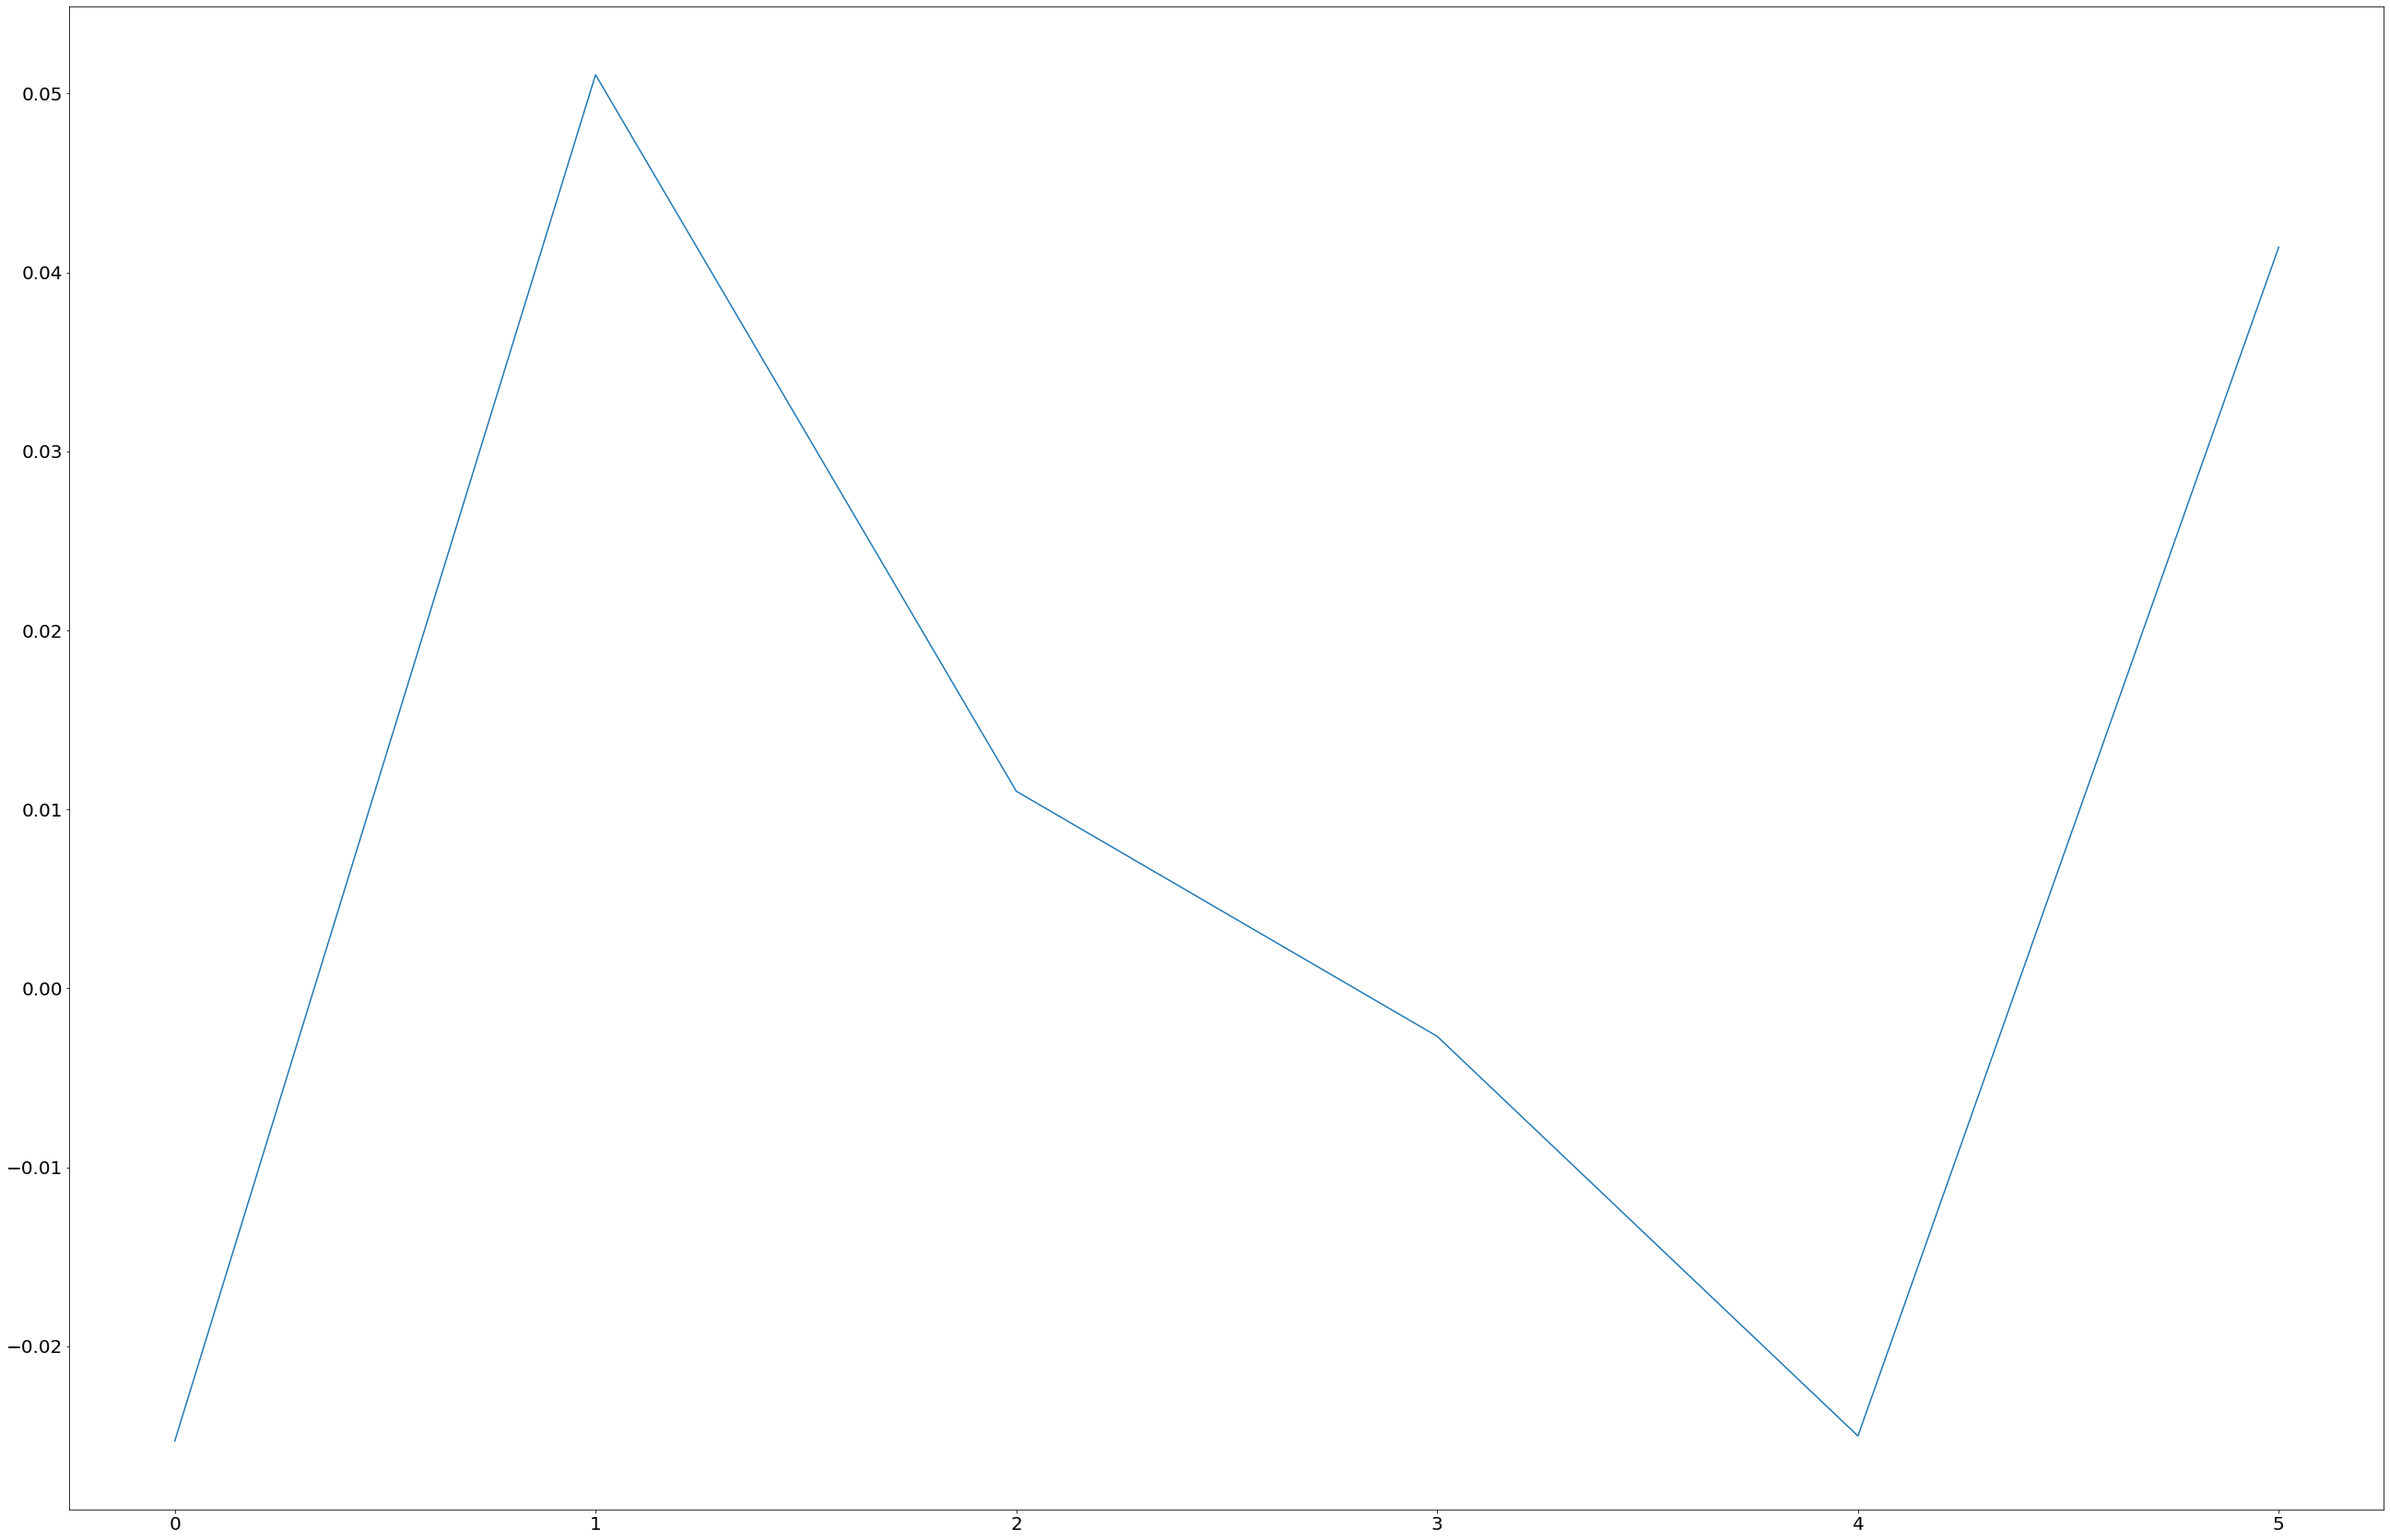

In [61]:
plt.plot(model3_est, label = 'forecast')